In [ ]:
import torch, gzip, time
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
import _pickle as pickle
from torch.utils.data import TensorDataset, DataLoader
# import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

dtype=torch.cuda.FloatTensor
import matplotlib.pyplot as plt
%matplotlib notebook

# Scalar-to-scalar linear regression
First, just linear regression, no feature transform

<IPython.core.display.Javascript object>


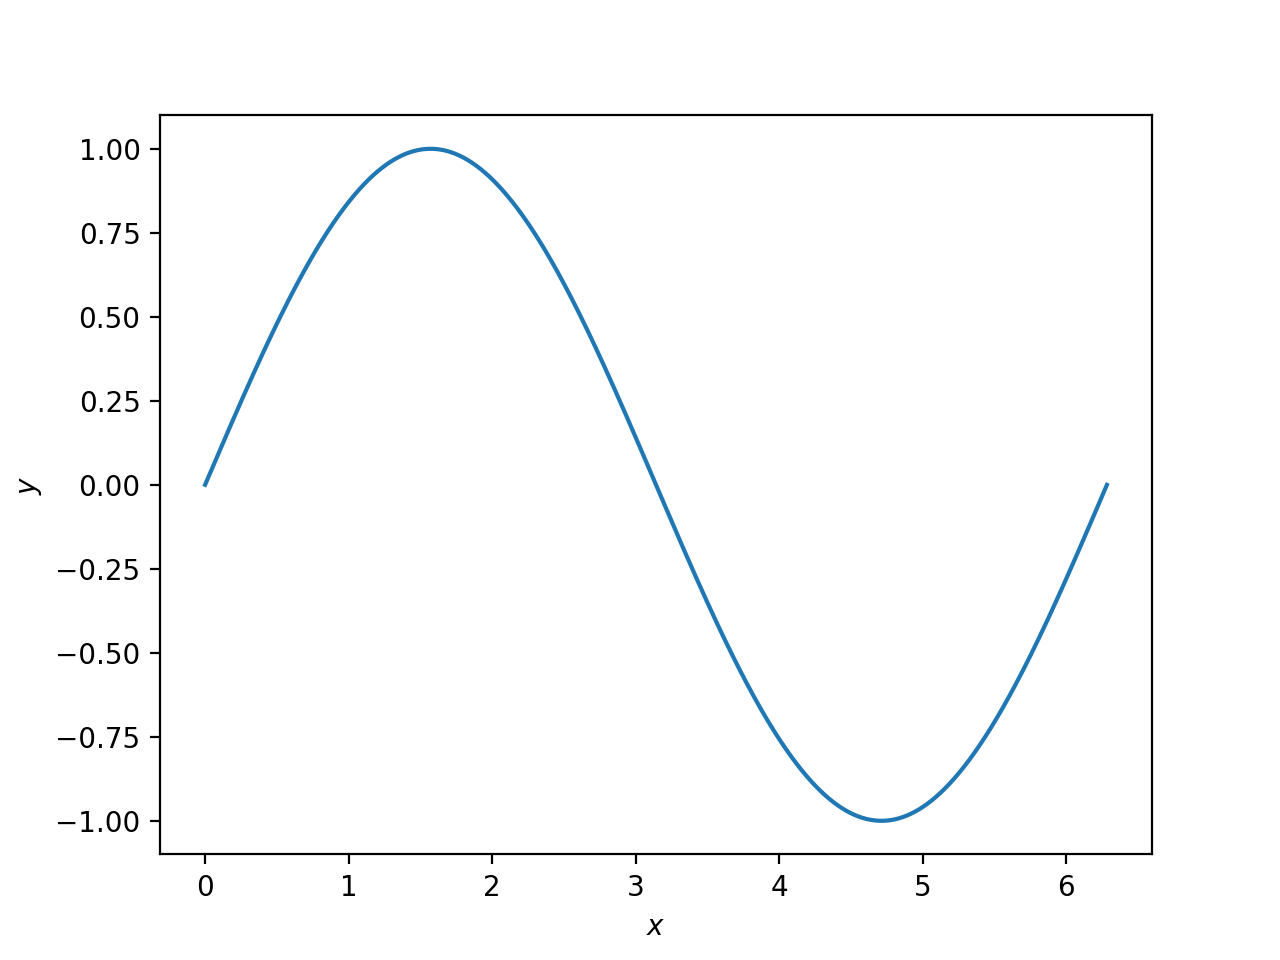

(6284,) (6284,)


In [4]:
x=np.arange(0,2*np.pi,0.001)
y=np.sin(x)
plt.figure()
plt.plot(x,y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()
print(x.shape,y.shape)

Linear model
$$\mathbf{y} =[\mathbf{x}, \mathbf{1}]\mathbf{a}\\
\arg\max_{\mathbf{a}} (\mathbf{y}-\mathbf{X}\mathbf{a})^\top(\mathbf{y}-\mathbf{X}\mathbf{a})\\
\arg\max_{\mathbf{a}} \mathbf{y}^\top\mathbf{y}+ \mathbf{a}^\top\mathbf{X}^\top\mathbf{X}\mathbf{a}-2\mathbf{a}^\top\mathbf{X}^\top\mathbf{y}\\
\frac{\partial \mathcal{J}}{\partial \mathbf{a}}=2\mathbf{X}^\top\mathbf{X}\mathbf{a}-2\mathbf{X}^\top\mathbf{y}=0\\
\mathbf{a}=(\mathbf{X}^\top\mathbf{X})^{-1}\mathbf{X}^\top\mathbf{y}$$

In [5]:
tic=time.time()
X=np.concatenate(([x], [np.ones(y.shape[0])]), axis=0) # append dummy ones
a=np.linalg.pinv(X.dot(X.T)).dot(X.dot(y))
toc=time.time()
yh=a.dot(X)
print(a)
print(toc-tic)

[-0.30384534  0.95453012]
0.0018155574798583984


<IPython.core.display.Javascript object>


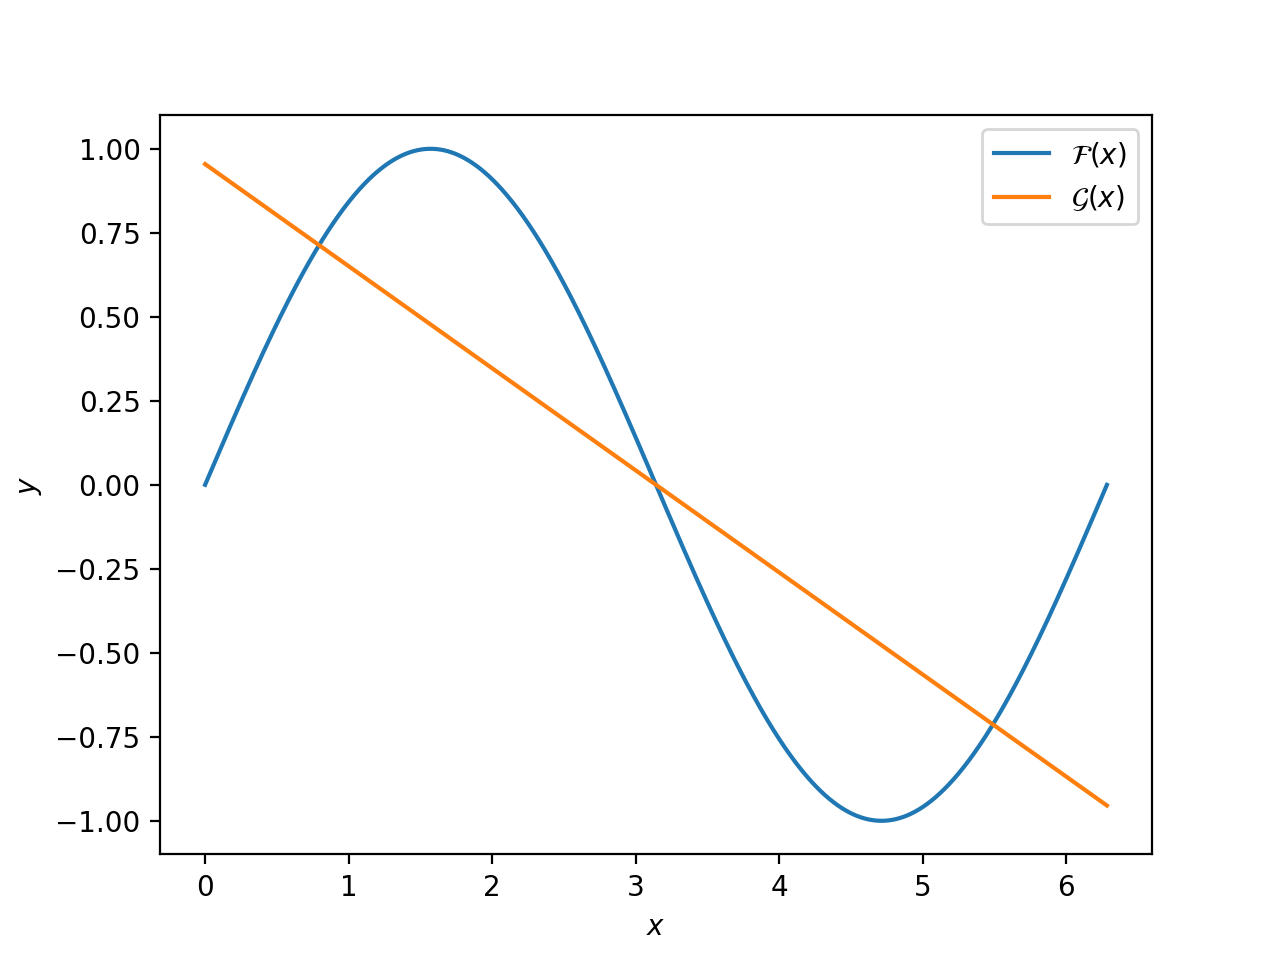

In [6]:
plt.figure()
plt.plot(x,y, label=r'$\mathcal{F}(x)$')
plt.plot(X[[0,0],[0,-1]], X[[[0,1],[0,1]],[[0,0],[-1,-1]]].dot(a), label=r'$\mathcal{G}(x)$')
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()


Non-linear feature transform (cubic)

<IPython.core.display.Javascript object>


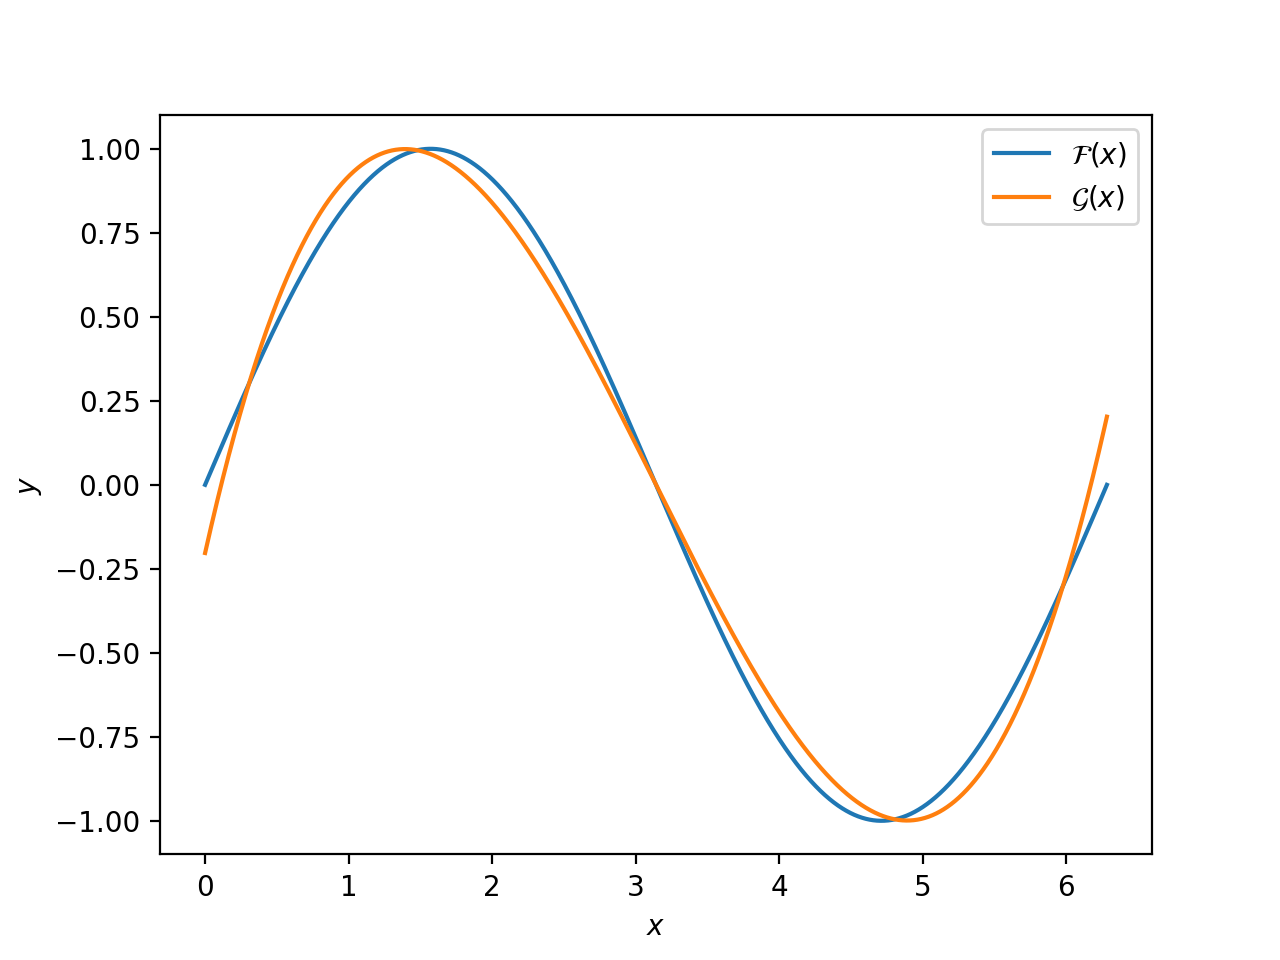

In [7]:
x=np.arange(0,2*np.pi,0.001)
y=np.sin(x)
X=np.concatenate(([x**3], [x**2], [x], np.ones((1, y.shape[0]))), axis=0)
a=np.linalg.pinv(X.dot(X.T)).dot(X).dot(y)
yh=a.dot(X)
plt.figure()
plt.plot(x, y, label=r'$\mathcal{F}(x)$')
plt.plot(x, yh, label=r'$\mathcal{G}(x)$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()
plt.show()

Non-linear feature transform (tanh)

<IPython.core.display.Javascript object>


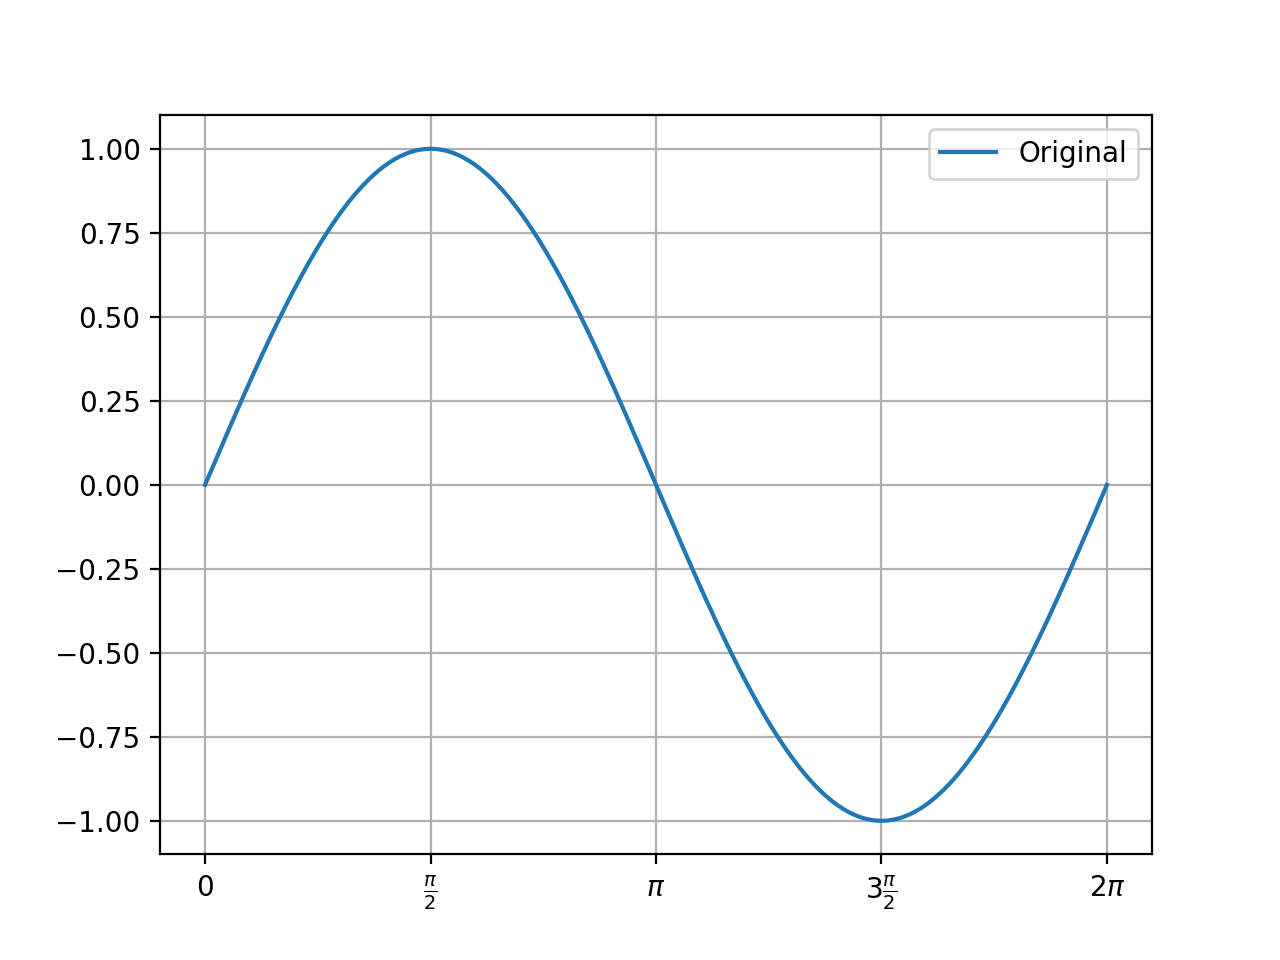

In [8]:
x=np.arange(0,2*np.pi,0.001)
y=np.sin(x)
plt.figure()
plt.plot(x, y, label='Original')
plt.xticks([0, np.pi/2, np.pi, np.pi*1.5, np.pi*2], ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$3\frac{\pi}{2}$', r'$2\pi$'])
plt.grid()
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


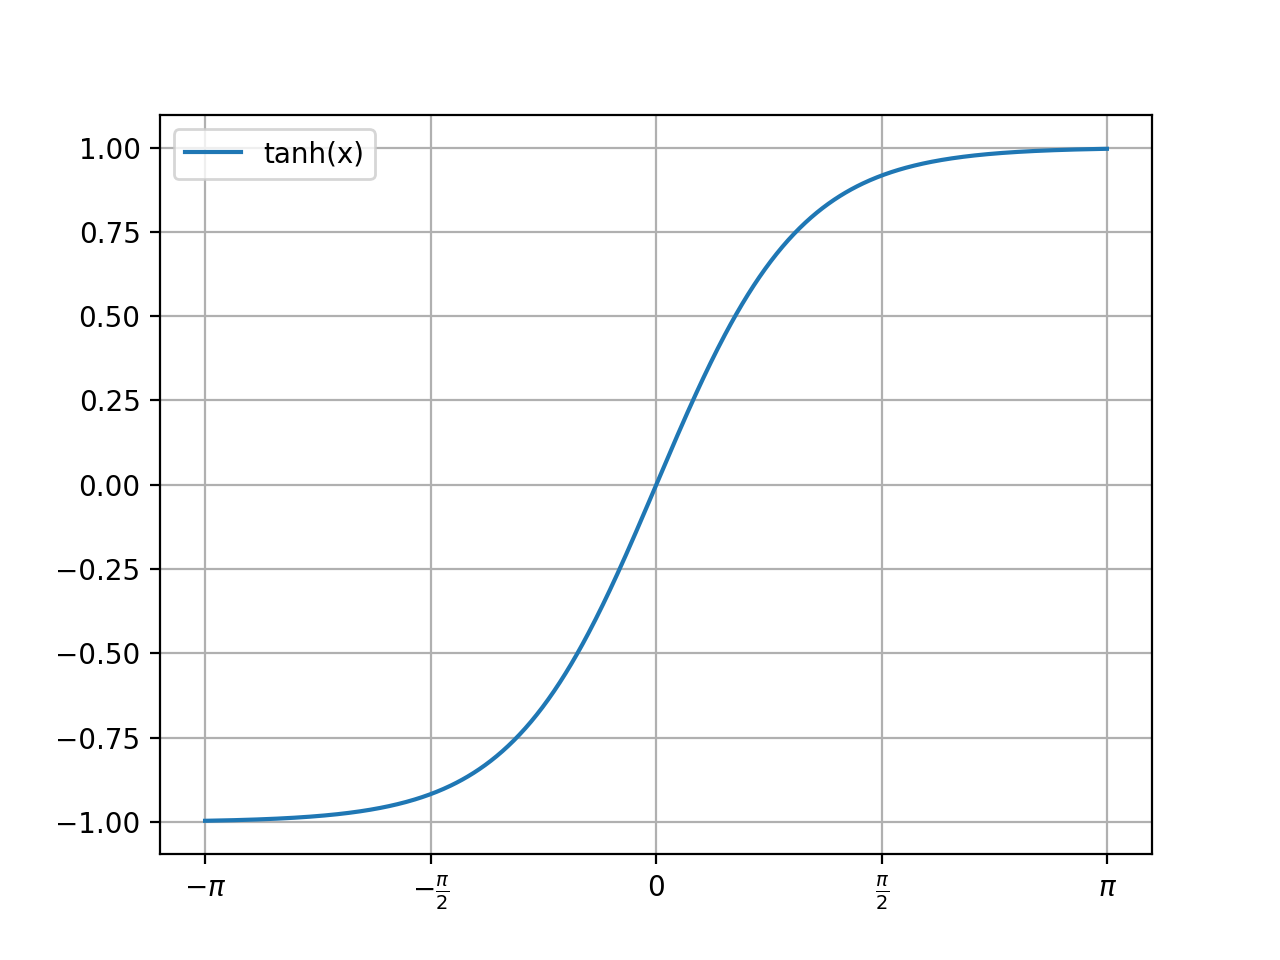

In [10]:
x=np.arange(-np.pi,np.pi,0.01)
y=np.tanh(x)
plt.figure()
plt.plot(x, y, label='tanh(x)')
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], 
           [r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$'])
plt.legend()
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


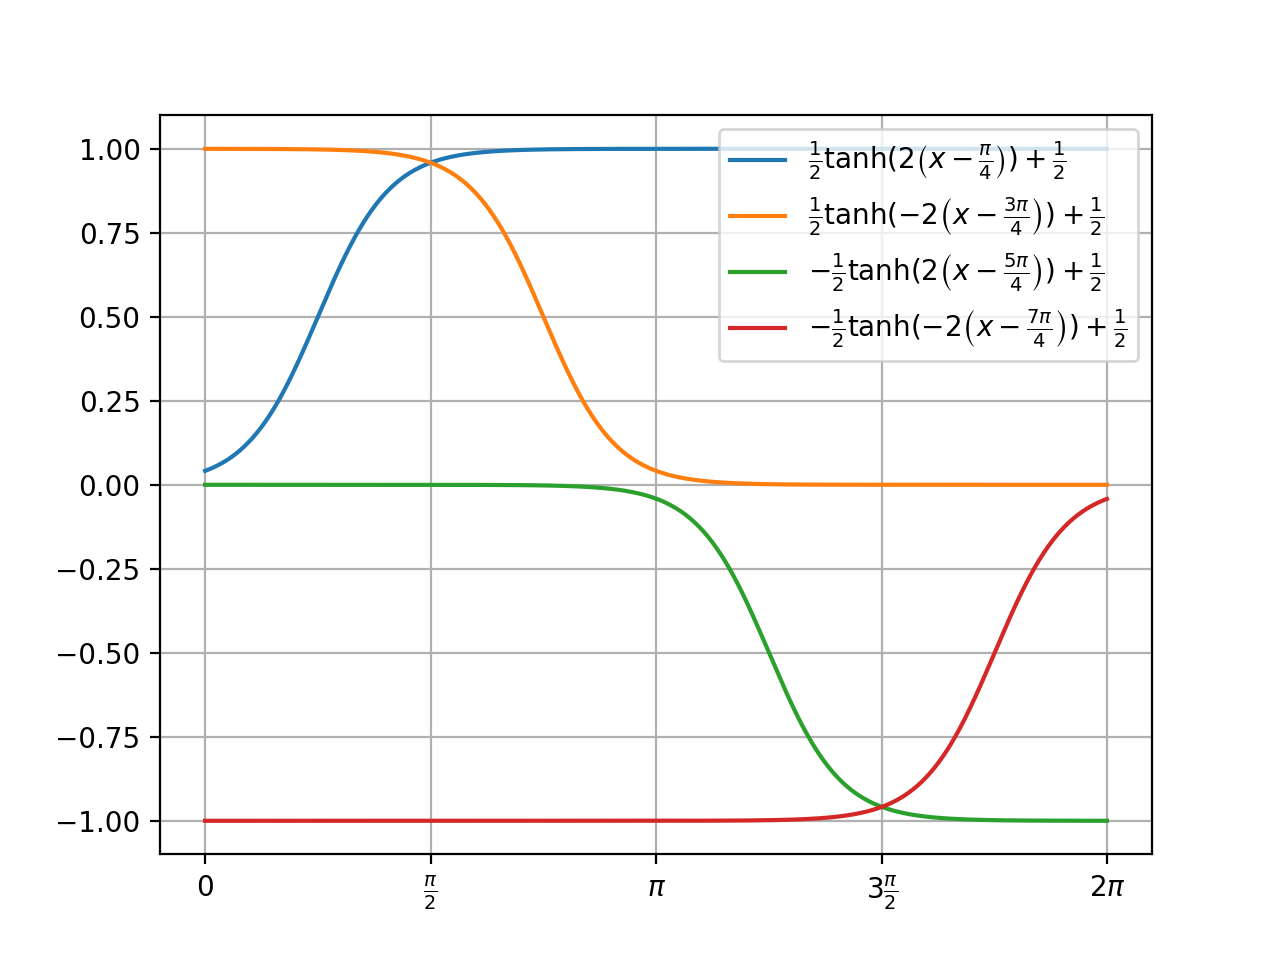

In [14]:
x=np.arange(0,2*np.pi,0.01)
y=np.sin(x)
h1=np.tanh(2*(x-np.pi/4))*.5+.5
h2=np.tanh(-2*(x-3*np.pi/4))*.5+.5
h3=-(np.tanh(2*(x-5*np.pi/4))*.5+.5)
h4=-(np.tanh(-2*(x-7*np.pi/4))*.5+.5)
plt.figure()
plt.plot(x, h1, label=r'$\frac{1}{2}\tanh(2\left(x-\frac{\pi}{4}\right))+\frac{1}{2}$')
plt.plot(x, h2, label=r'$\frac{1}{2}\tanh(-2\left(x-\frac{3\pi}{4}\right))+\frac{1}{2}$')
plt.plot(x, h3, label=r'$-\frac{1}{2}\tanh(2\left(x-\frac{5\pi}{4}\right))+\frac{1}{2}$')
plt.plot(x, h4, label=r'$-\frac{1}{2}\tanh(-2\left(x-\frac{7\pi}{4}\right))+\frac{1}{2}$')
plt.xticks([0, np.pi/2, np.pi, np.pi*1.5, np.pi*2], 
           ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$3\frac{\pi}{2}$', r'$2\pi$'])
plt.legend()
plt.grid()
plt.show()

(629,) (629,)


<IPython.core.display.Javascript object>


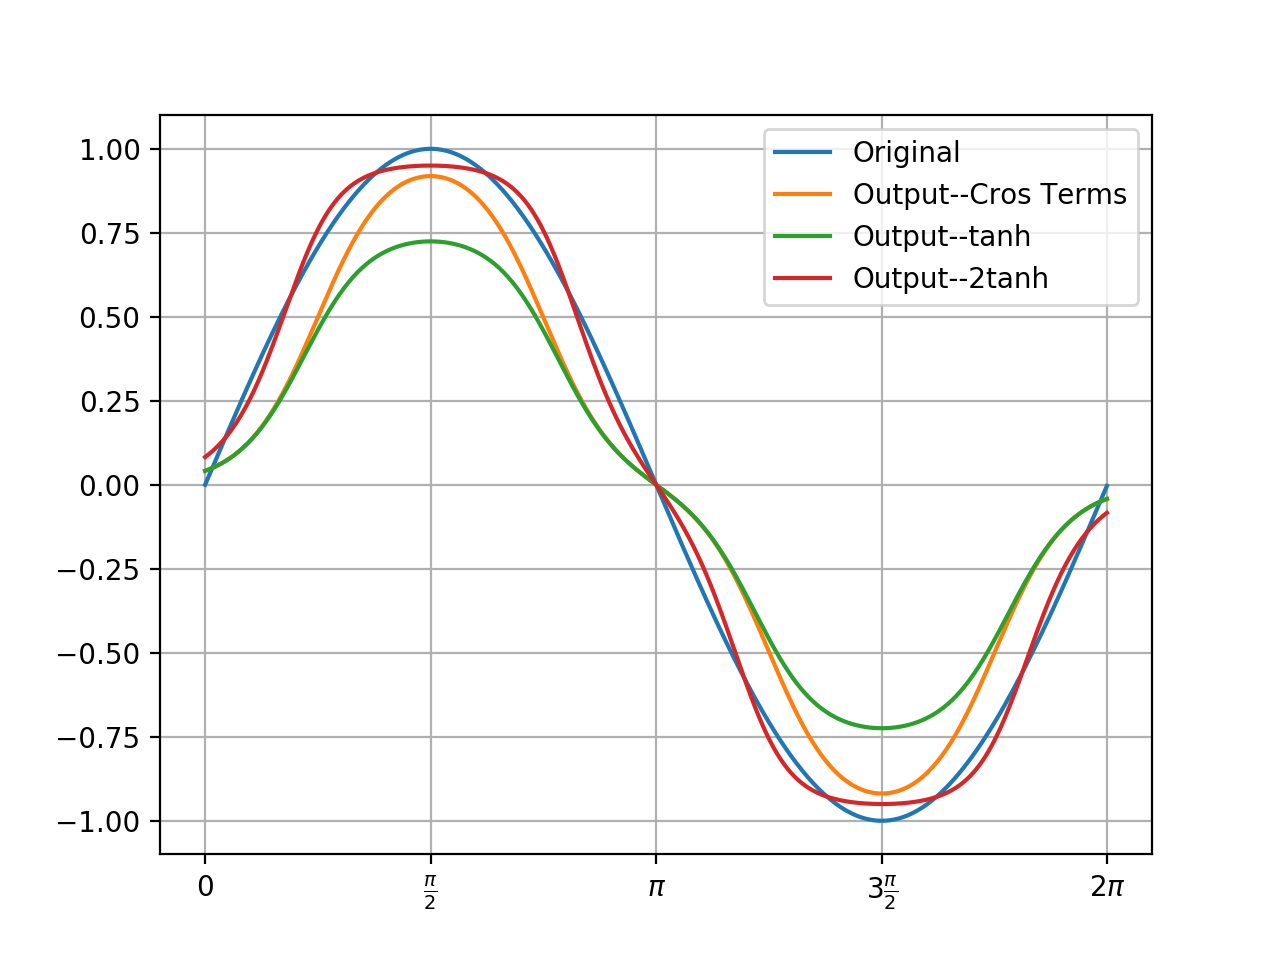

In [15]:
yh1=h1*h2-h3*h4
yh2=np.tanh((h1+h2-1))+np.tanh((h3+h4+1))
yh3=np.tanh(2*(h1+h2-1))+np.tanh(2*(h3+h4+1))
plt.figure()
plt.plot(x, y, label='Original')
plt.plot(x, yh1, label='Output--Cros Terms')
plt.plot(x, yh2, label='Output--tanh')
plt.plot(x, yh3, label='Output--2tanh')
plt.xticks([0, np.pi/2, np.pi, np.pi*1.5, np.pi*2], 
           ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$3\frac{\pi}{2}$', r'$2\pi$'])
plt.legend()
plt.grid()
plt.show()

# Classification

<IPython.core.display.Javascript object>


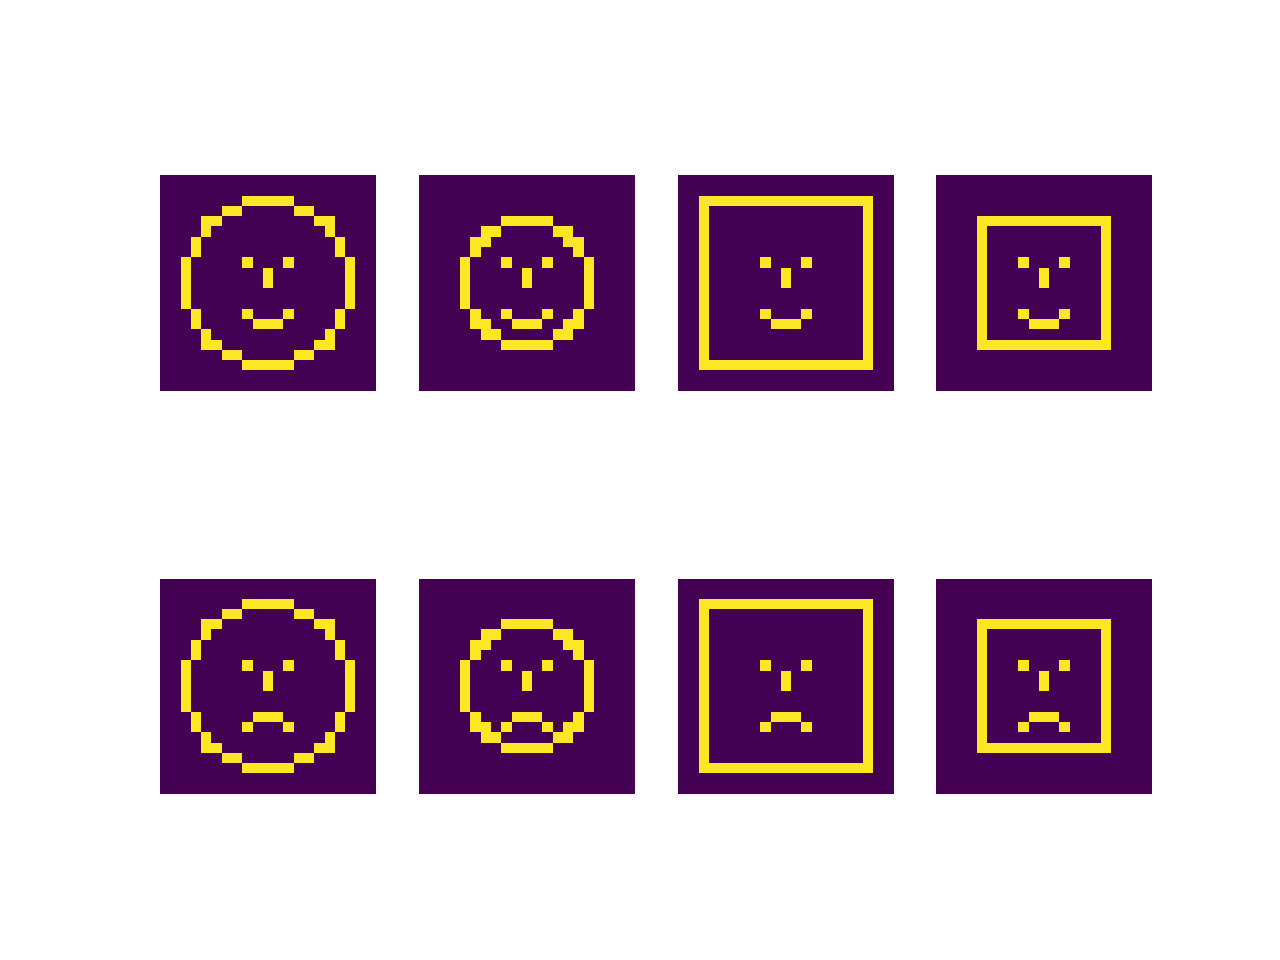

<IPython.core.display.Javascript object>


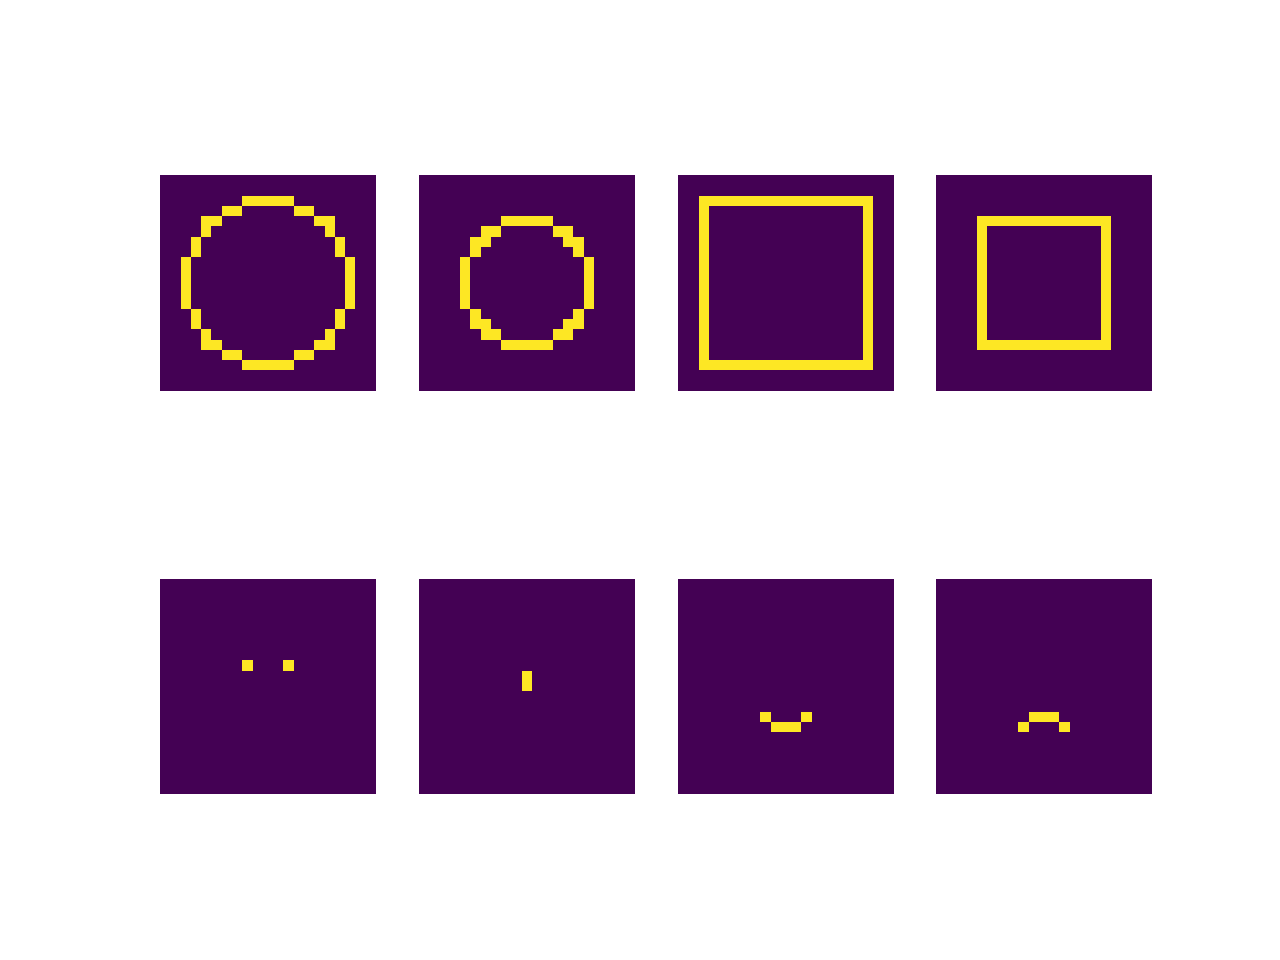

In [16]:
r=8
w1=np.zeros((21,21))
x1=np.array([np.arange(21)]).T
x2=np.array([np.arange(21)])
X1, X2=np.meshgrid(x1,x2)
R=(X1-10)**2+(X2-10)**2
x1c, x2c=np.where(np.all([[R<(r+.5)**2],[R>(r-.5)**2]], axis=0).squeeze())
w1[x1c, x2c]=1
# plt.figure()
# plt.imshow(w1)
# plt.close()
r=6
w2=np.zeros((21,21))
R=(X1-10)**2+(X2-10)**2
x1c, x2c=np.where(np.all([[R<(r+.5)**2],[R>(r-.5)**2]], axis=0).squeeze())
w2[x1c, x2c]=1
# plt.figure()
# plt.imshow(w2)
# plt.close()
r=8
w3=np.zeros((21,21))
w3[2*np.ones((1,17),dtype=np.int8), 2:19]=1
w3[18*np.ones((1,17),dtype=np.int8), 2:19]=1
w3[2:19 ,2*np.ones((1,17),dtype=np.int8)]=1
w3[2:19 ,18*np.ones((1,17),dtype=np.int8)]=1
# plt.imshow(w3)
r=6
w4=np.zeros((21,21))
w4[4*np.ones((1,13),dtype=np.int8), 4:17]=1
w4[16*np.ones((1,13),dtype=np.int8), 4:17]=1
w4[4:17, 4*np.ones((1,13),dtype=np.int8)]=1
w4[4:17, 16*np.ones((1,13),dtype=np.int8)]=1
# plt.imshow(w4)
w5=np.zeros((21,21))
w5[[8,8], [8,12]]=1;
# plt.imshow(w5)
w6=np.zeros((21,21))
w6[9:11, [10,10]]=1;
# plt.imshow(w6)
w7=np.zeros((21,21))
w7[[13,14,14,14,13], [8,9,10,11,12]]=1;
# plt.imshow(w7)
w8=np.zeros((21,21))
w8[[14,13,13,13,14], [8,9,10,11,12]]=1;
# plt.imshow(w7)
# plt.imshow(w1+w5+w6+w8)
# w1, w2, w3, w4
# w5, w6
# w7
# w8
X=np.zeros((8,21*21))
X[0,:]=(w1+w5+w6+w7).reshape((1,21*21))
X[1,:]=(w2+w5+w6+w7).reshape((1,21*21))
X[2,:]=(w3+w5+w6+w7).reshape((1,21*21))
X[3,:]=(w4+w5+w6+w7).reshape((1,21*21))
X[4,:]=(w1+w5+w6+w8).reshape((1,21*21))
X[5,:]=(w2+w5+w6+w8).reshape((1,21*21))
X[6,:]=(w3+w5+w6+w8).reshape((1,21*21))
X[7,:]=(w4+w5+w6+w8).reshape((1,21*21))

W=np.zeros((8,21*21))
W[0,:]=w1.reshape((1,21*21))
W[1,:]=w2.reshape((1,21*21))
W[2,:]=w3.reshape((1,21*21))
W[3,:]=w4.reshape((1,21*21))
W[4,:]=w5.reshape((1,21*21))
W[5,:]=w6.reshape((1,21*21))
W[6,:]=w7.reshape((1,21*21))
W[7,:]=w8.reshape((1,21*21))


# 
%matplotlib notebook
plt.figure()
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(X[i,:].reshape((21,21)))
    plt.axis('off')
    plt.show()
    
plt.figure()
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(W[i,:].reshape((21,21)))
    plt.axis('off')
    plt.show()


# plt.close()

<IPython.core.display.Javascript object>


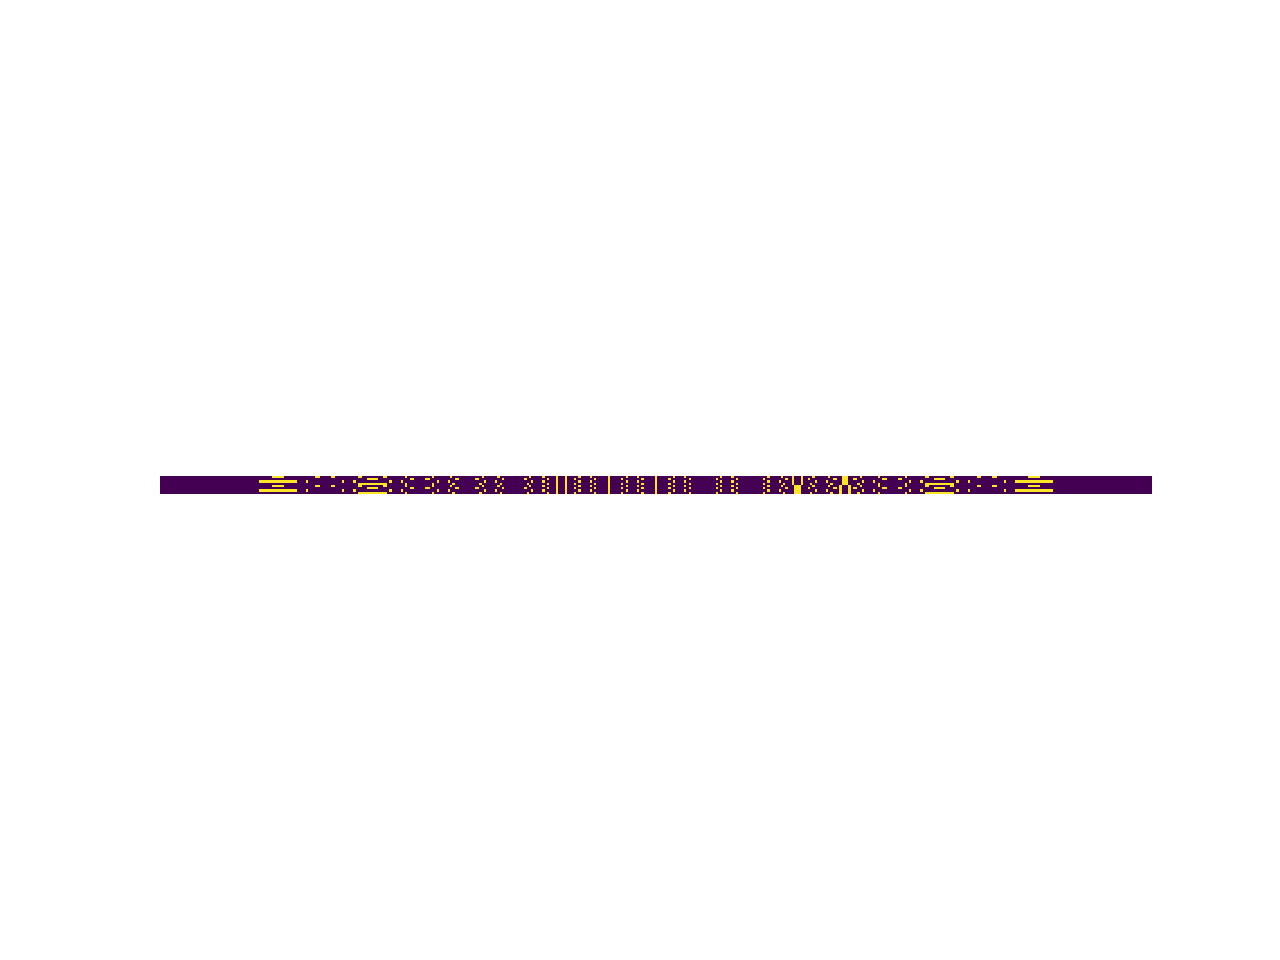

<IPython.core.display.Javascript object>


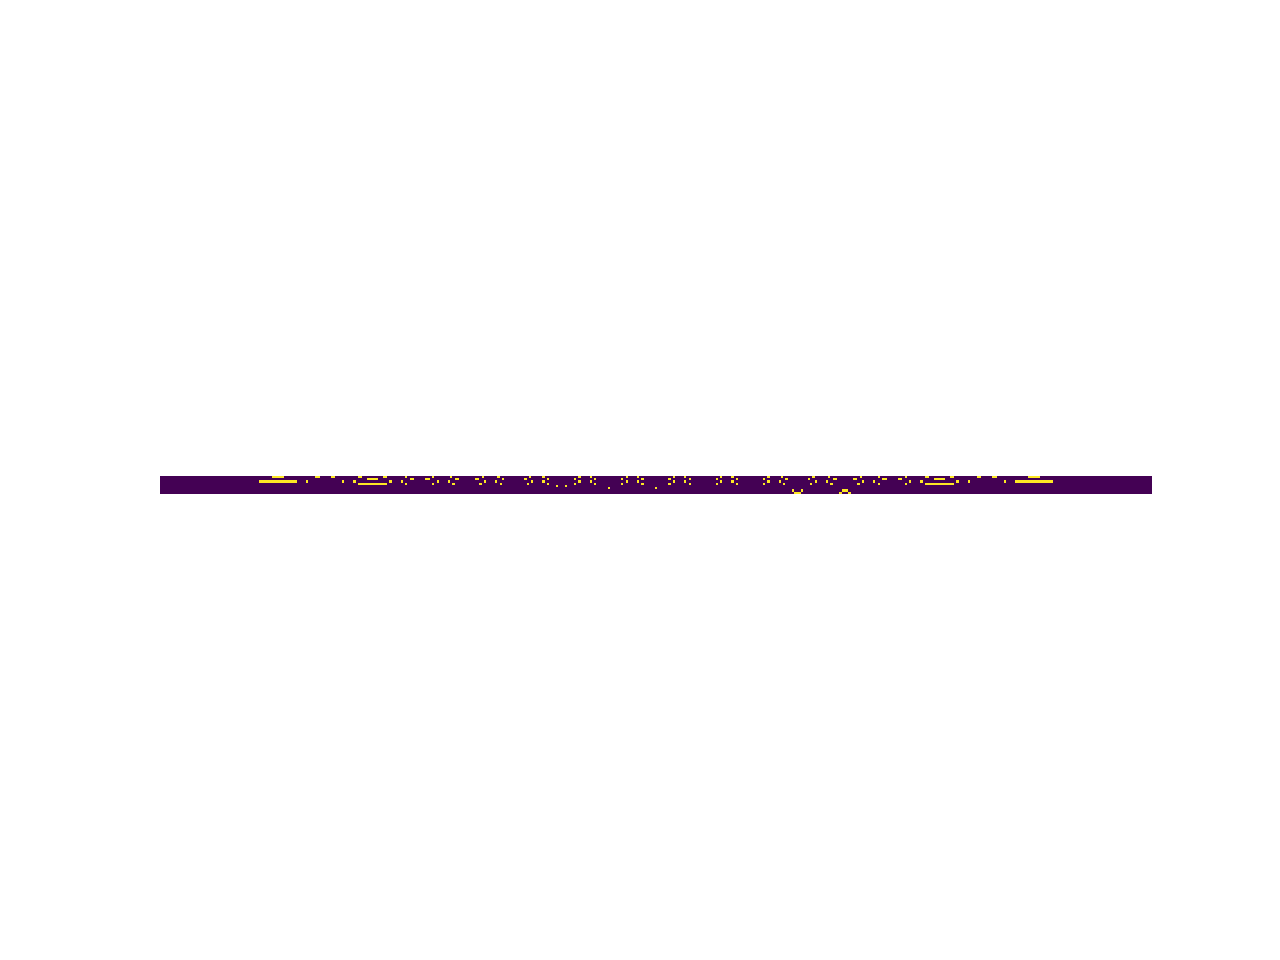

In [17]:
plt.figure()
plt.imshow(X)
# plt.colorbar()
# plt.xlabel('Features')
# plt.ylabel('Examples')
plt.axis("off")
plt.show()
plt.figure()
plt.imshow(W)
# plt.colorbar()
# plt.xlabel('Features')
# plt.ylabel('Examples')
plt.axis("off")
plt.show()

<IPython.core.display.Javascript object>


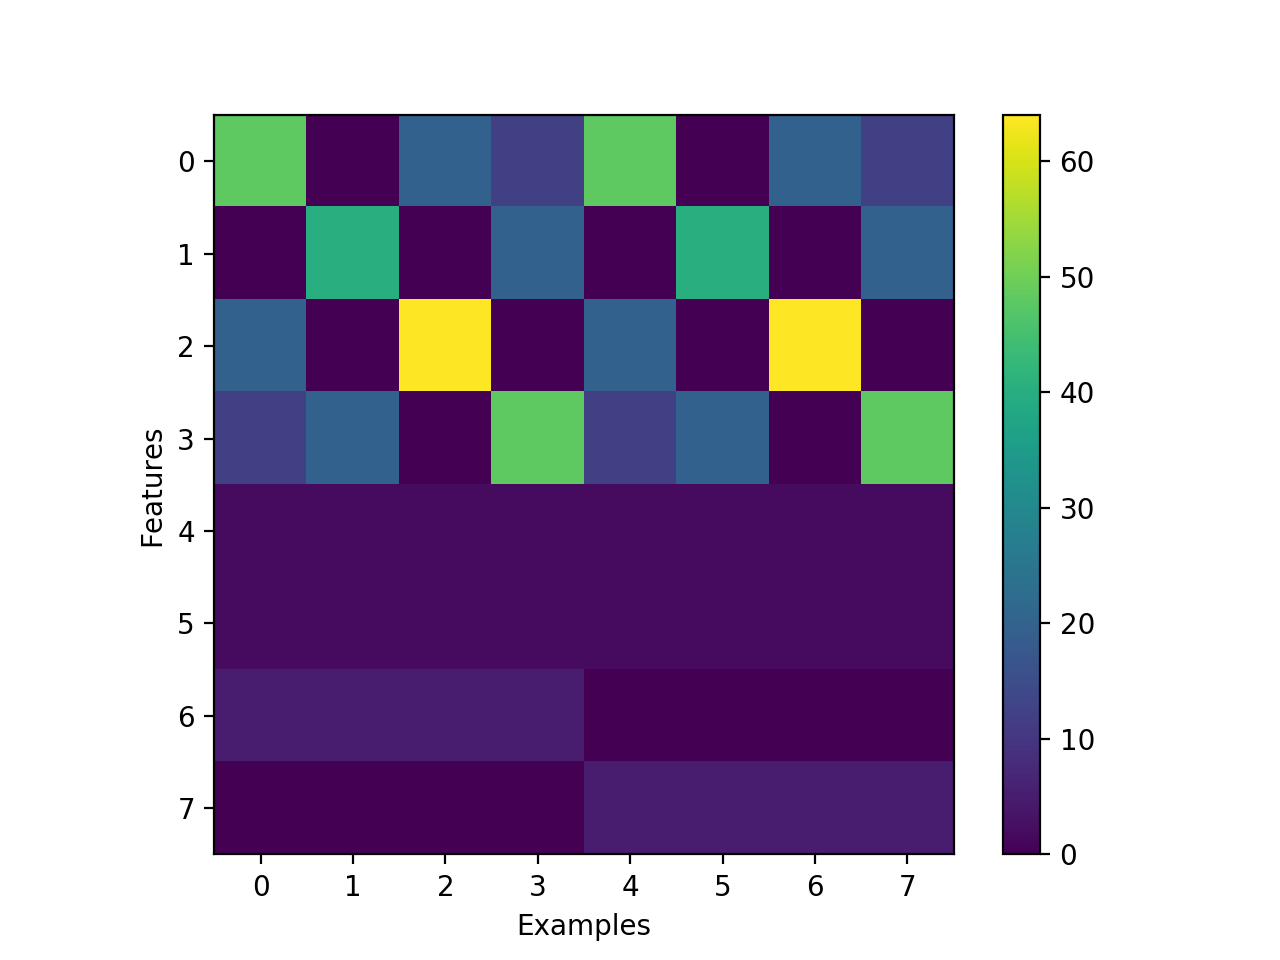

In [18]:
# %matplotlib qt
Z=W.dot(X.T)
plt.figure()
plt.imshow(Z)
plt.colorbar()
plt.ylabel('Features')
plt.xlabel('Examples')
plt.show()

<IPython.core.display.Javascript object>


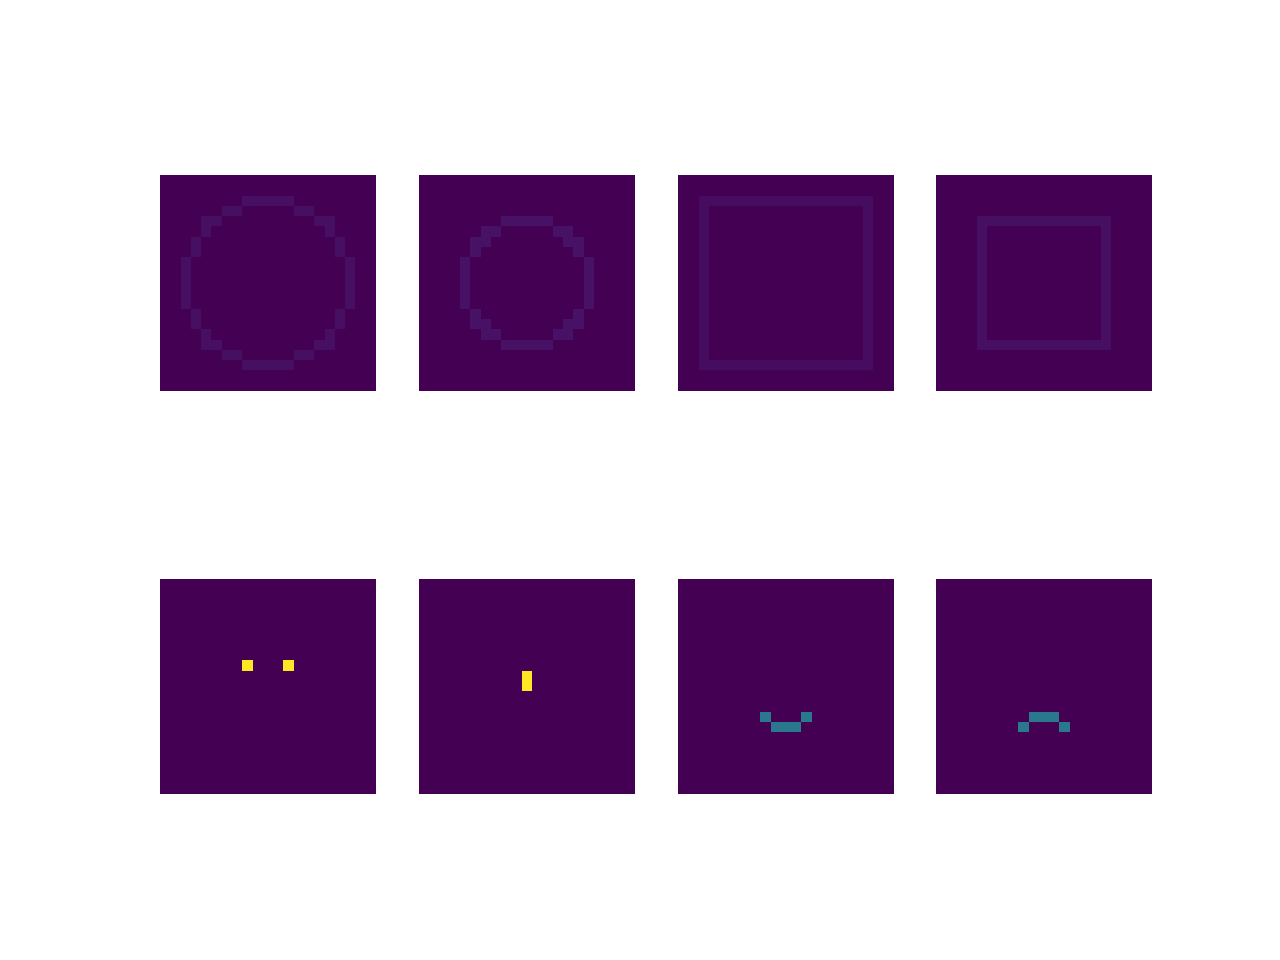

<IPython.core.display.Javascript object>


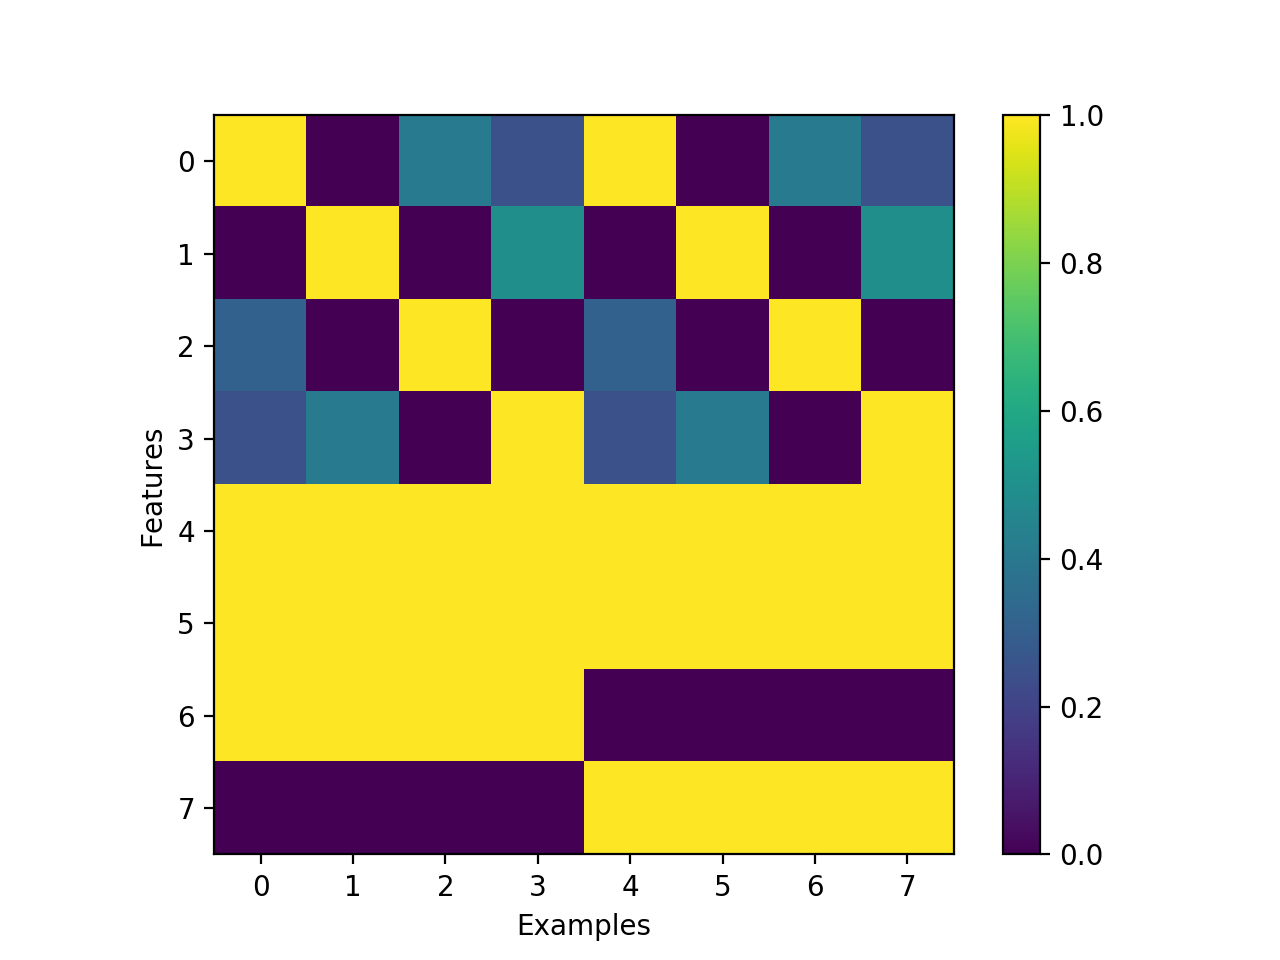

<IPython.core.display.Javascript object>


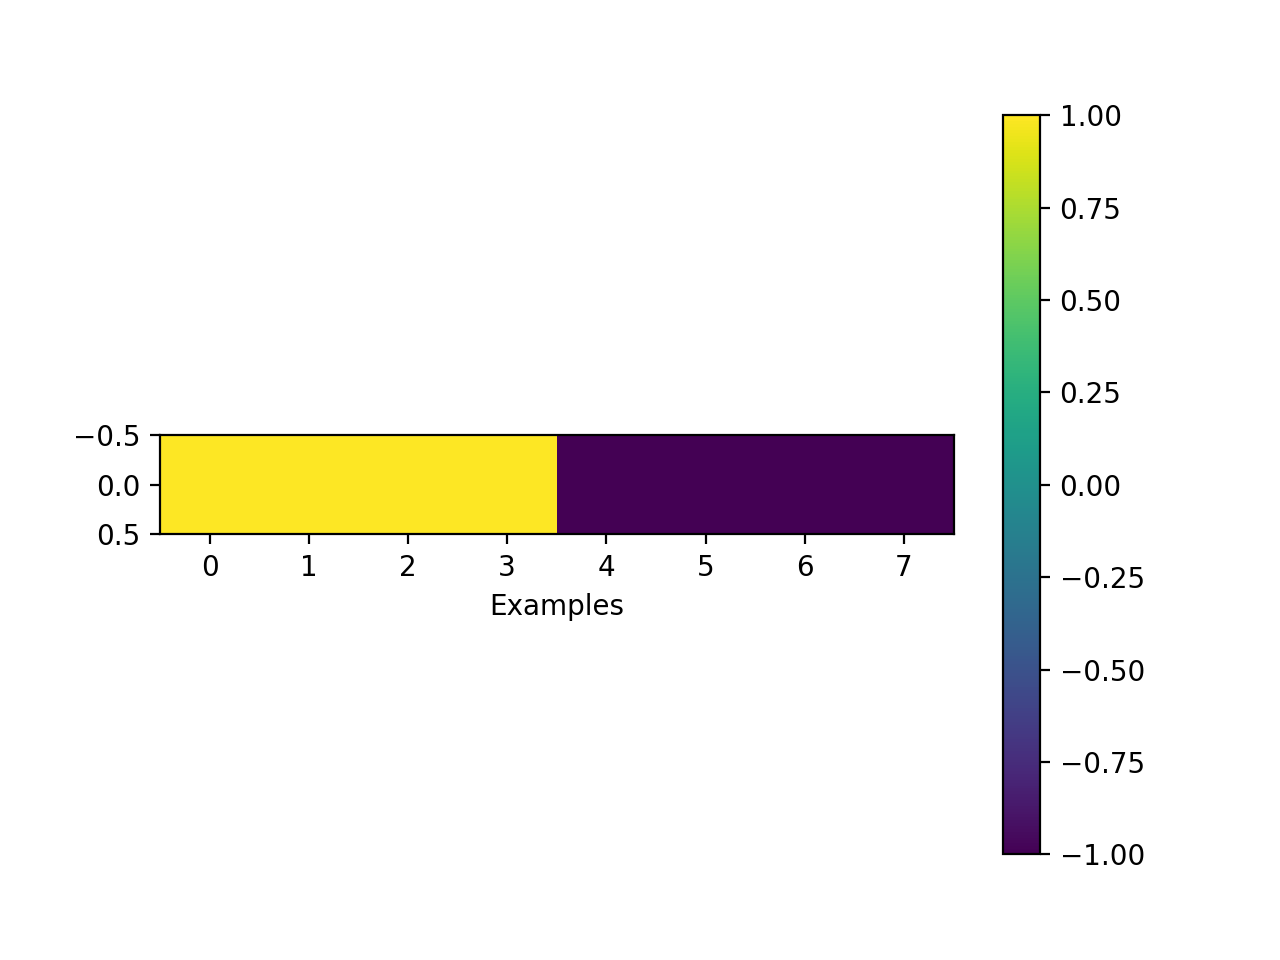

<IPython.core.display.Javascript object>


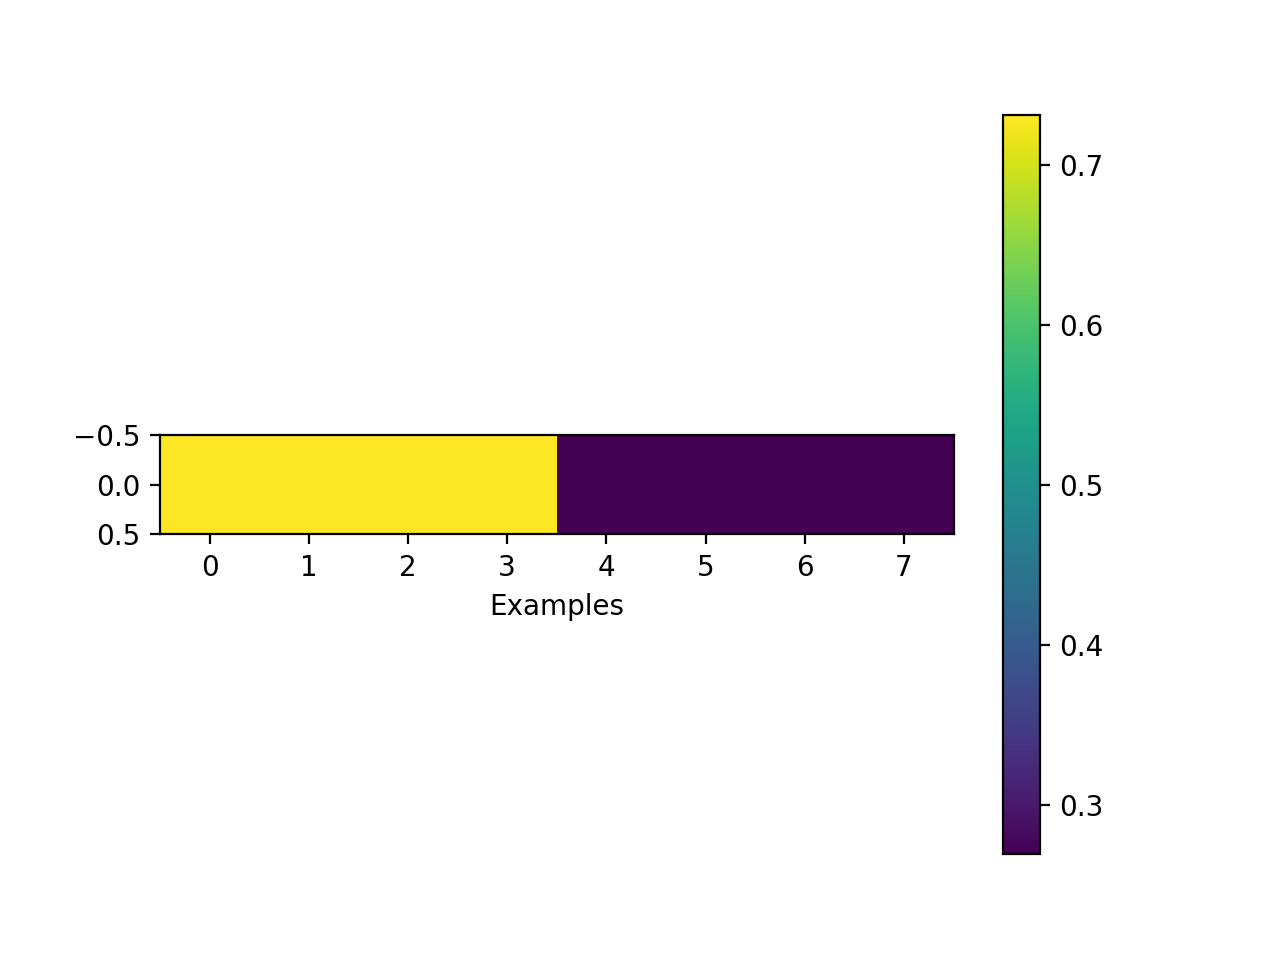

<IPython.core.display.Javascript object>


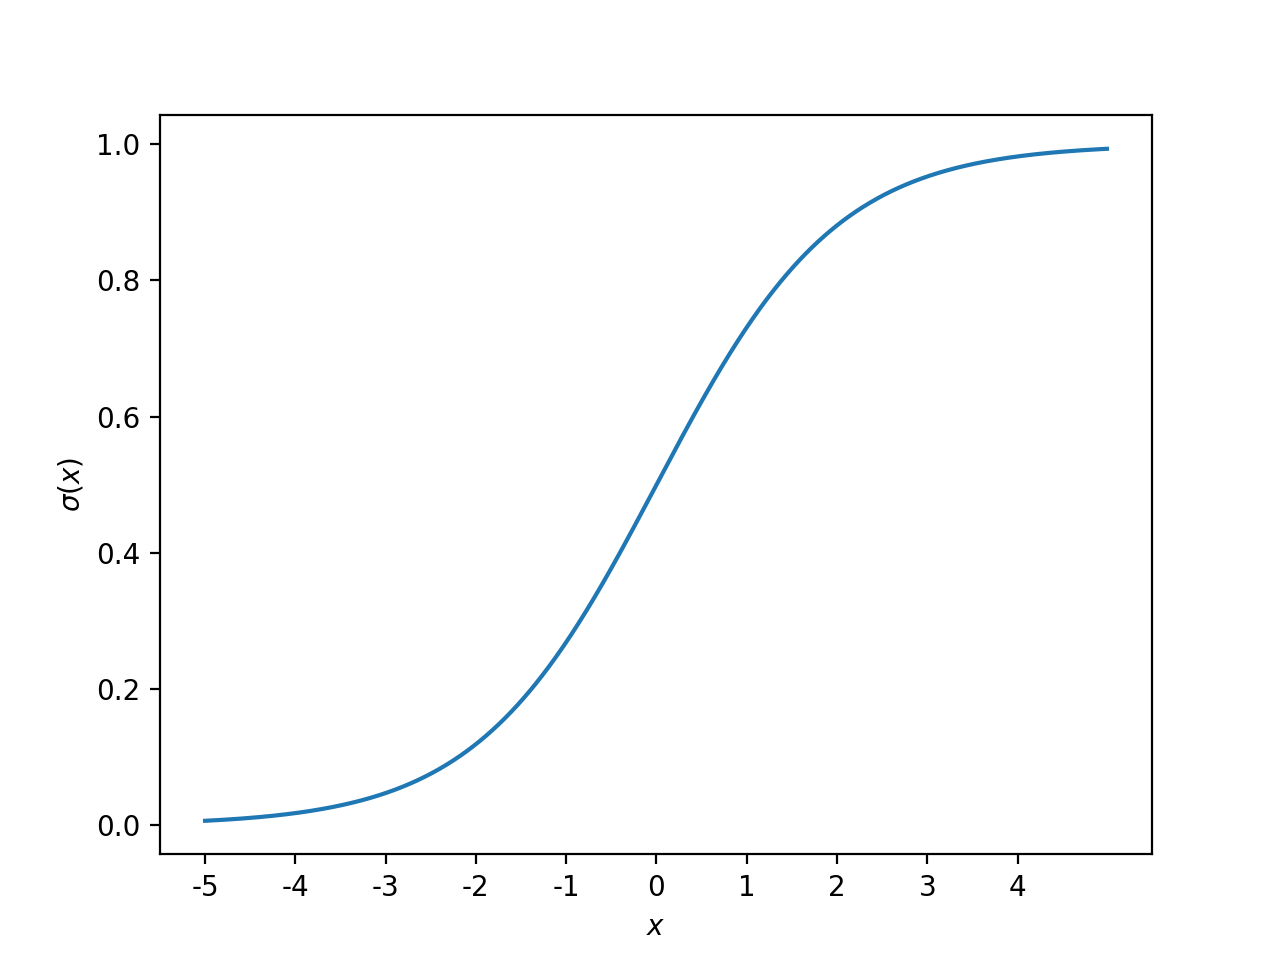

Text(0,0.5,'$\\sigma(x)$')

In [19]:
Wn=W/np.sum(W,axis=1).reshape((8,1))

plt.figure()
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(Wn[i,:].reshape((21,21)), vmin=0, vmax=np.max(Wn))
    plt.axis('off')
    plt.show()

Z=X.dot(Wn.T)
plt.figure()
plt.imshow(Z.T)
plt.colorbar()
plt.ylabel('Features')
plt.xlabel('Examples')

W2=np.array([[0,0,0,0,0,0,1,-1]])
Z2=Z.dot(W2.T)
plt.figure()
plt.imshow(Z2.T)
plt.colorbar()
plt.xlabel('Examples')

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

plt.figure()
plt.imshow(sigmoid(Z2.T))
plt.colorbar()
plt.xlabel('Examples')

plt.figure()
plt.plot(sigmoid(np.arange(-5,5,.01)))
plt.xticks(np.arange(0,1000,100), np.arange(-5,6).astype(str))
plt.xlabel(r'$x$')
plt.ylabel(r'$\sigma(x)$')





<IPython.core.display.Javascript object>


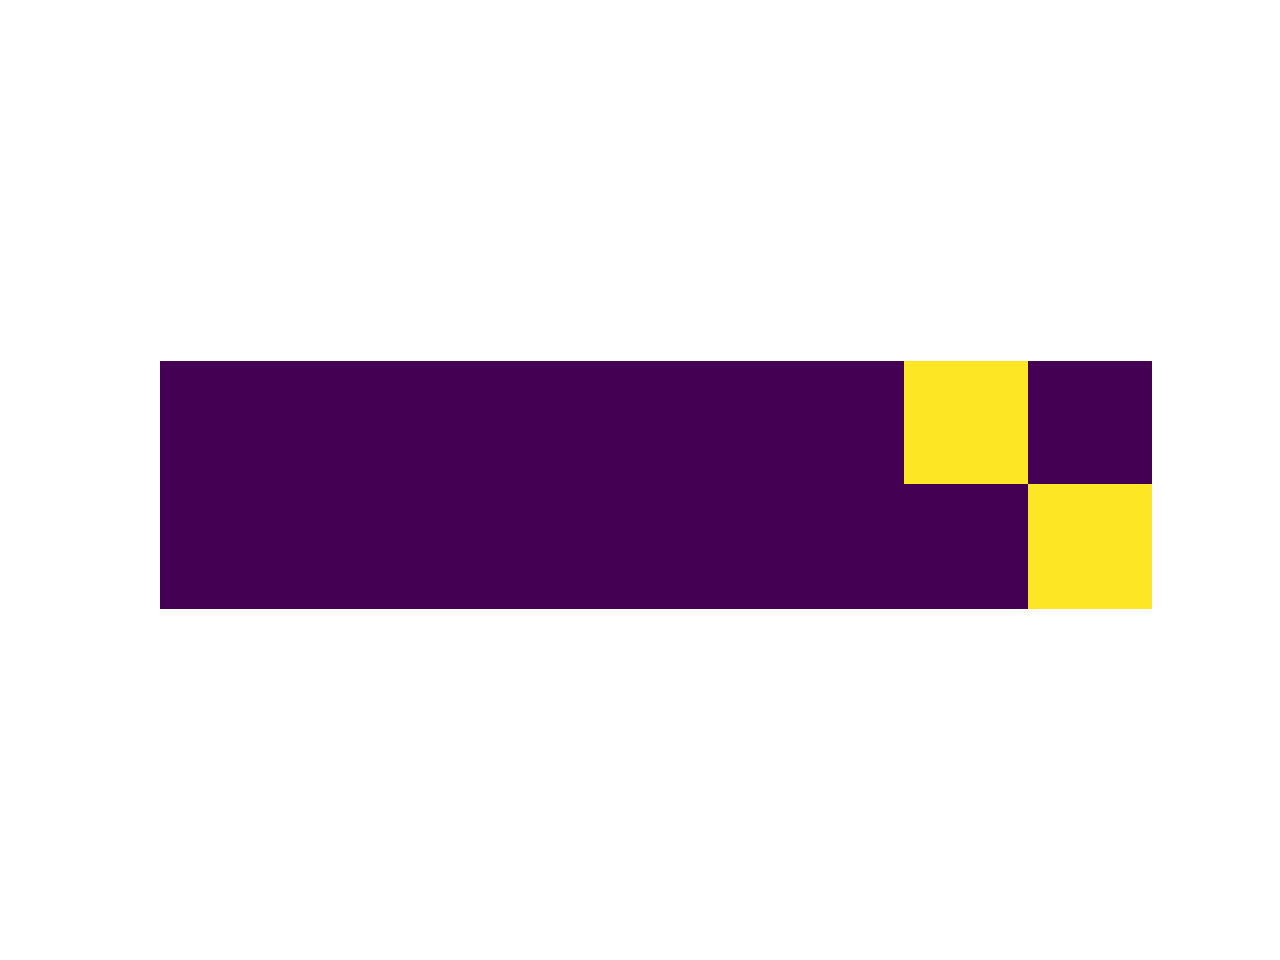

<IPython.core.display.Javascript object>


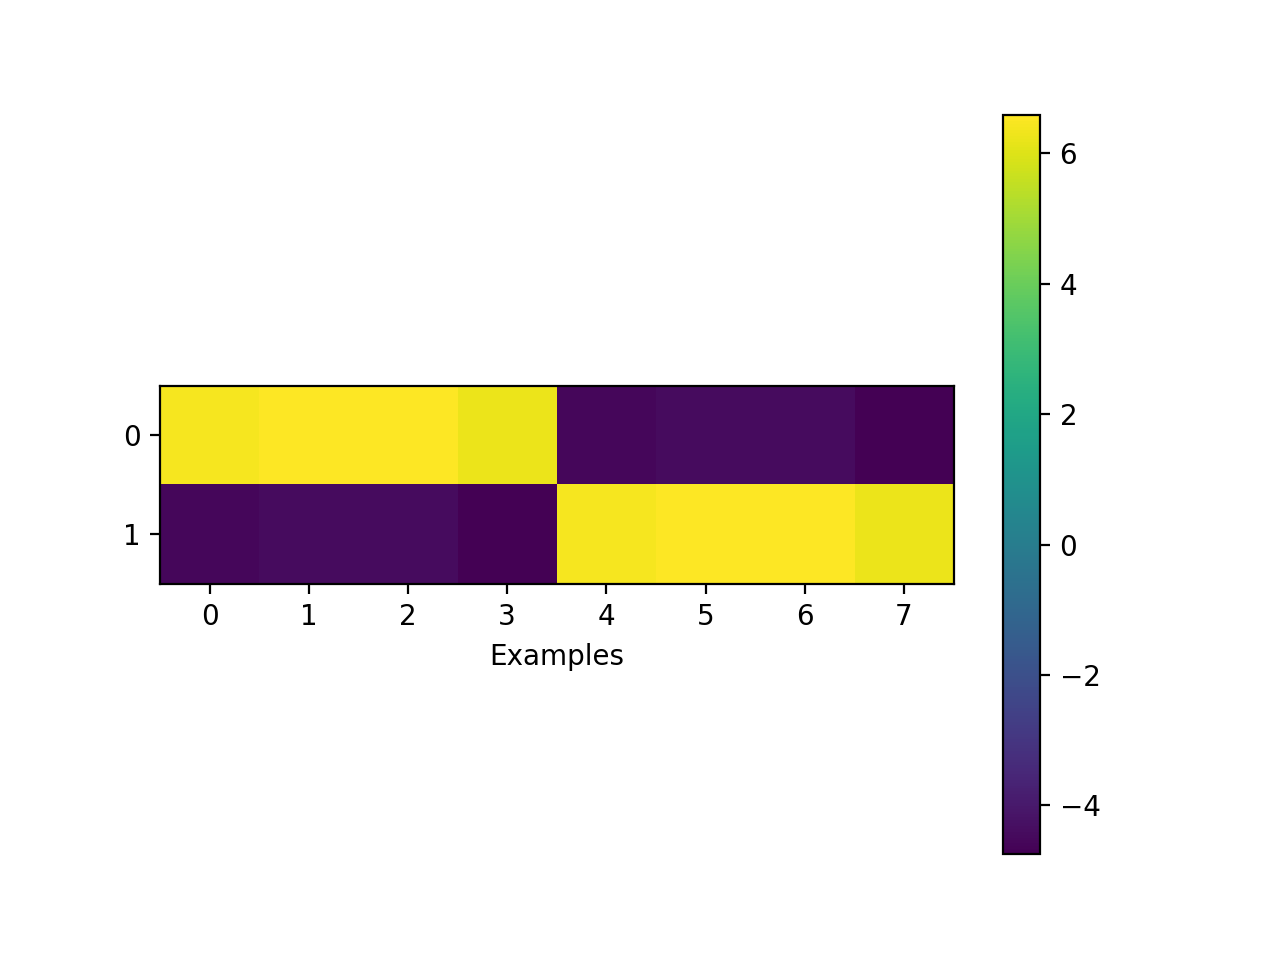

Text(0.5,0,'Examples')

In [20]:
W2=np.array([[-1,-1,-1,-1,-1,-1,10,-1],[-1,-1,-1,-1,-1,-1,-1,10]])
plt.figure()
plt.imshow(W2)
plt.axis('off')
plt.xlabel('Examples')


Z2=Z.dot(W2.T)
plt.figure()
plt.imshow(Z2.T)
plt.colorbar()
plt.xlabel('Examples')





## Multiclass classification

<IPython.core.display.Javascript object>


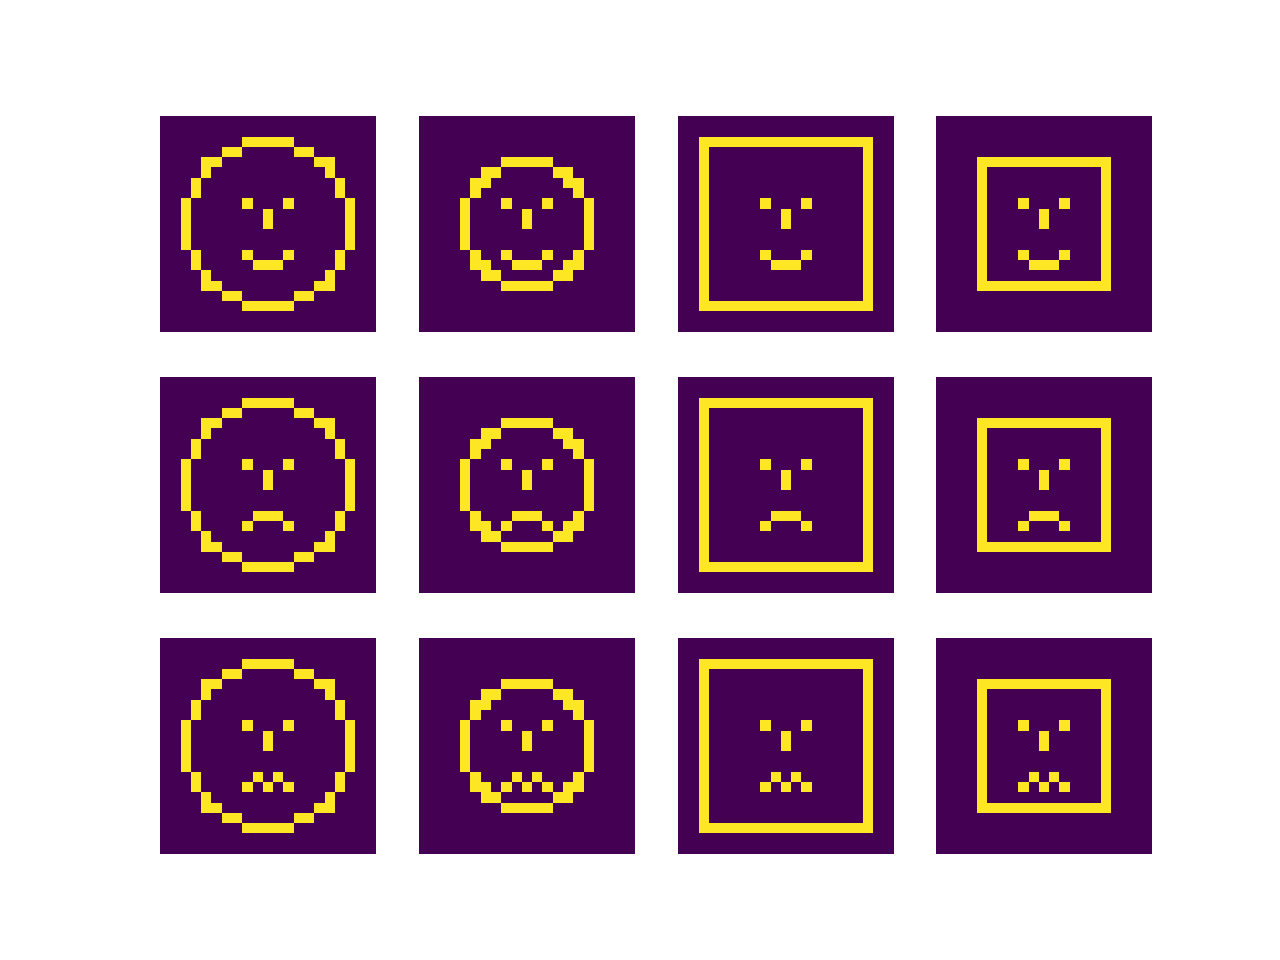

<IPython.core.display.Javascript object>


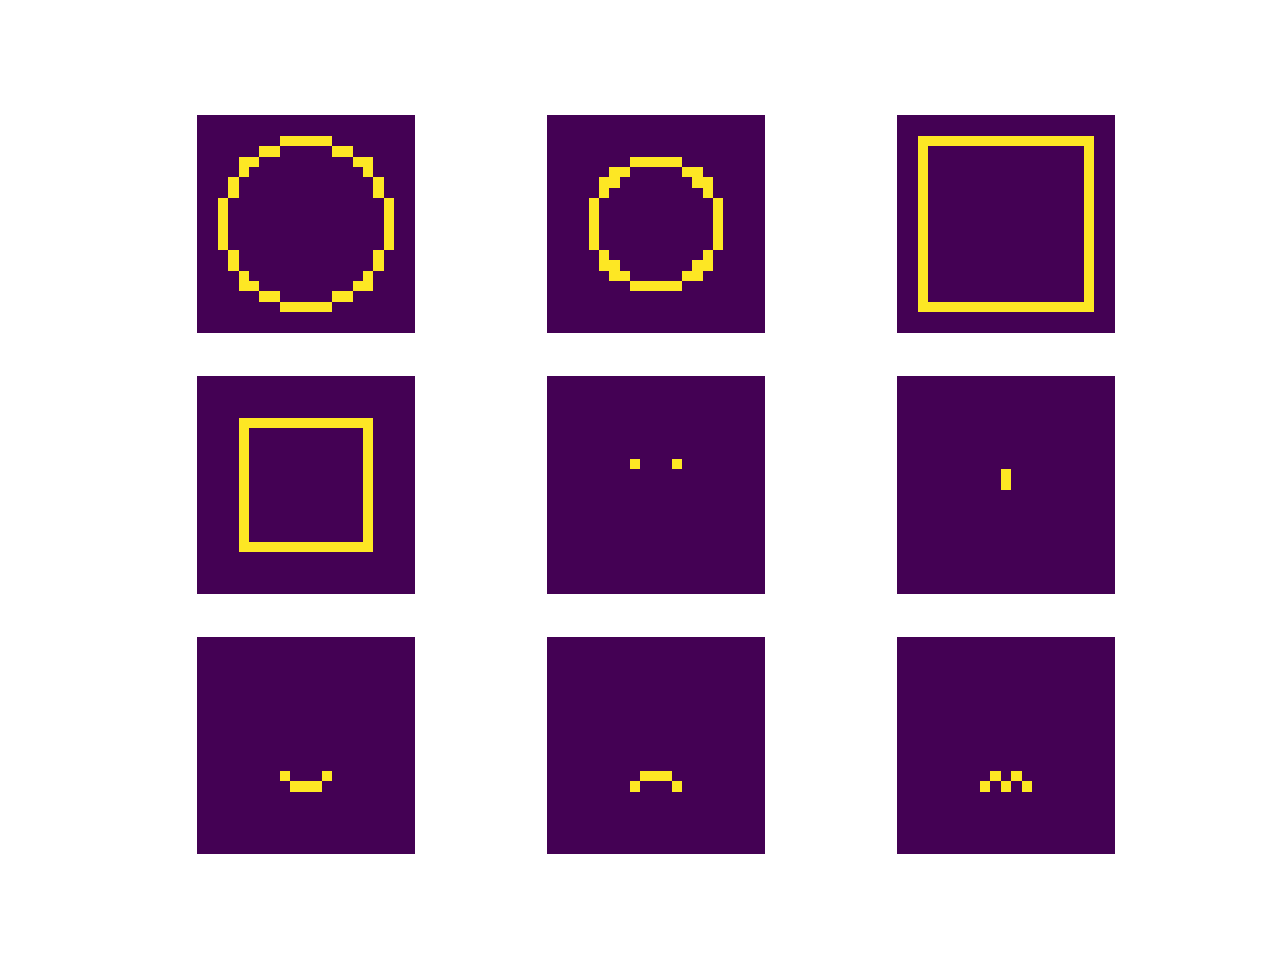

In [21]:
r=8
w1=np.zeros((21,21))
x1=np.array([np.arange(21)]).T
x2=np.array([np.arange(21)])
X1, X2=np.meshgrid(x1,x2)
R=(X1-10)**2+(X2-10)**2
x1c, x2c=np.where(np.all([[R<(r+.5)**2],[R>(r-.5)**2]], axis=0).squeeze())
w1[x1c, x2c]=1
# plt.figure()
# plt.imshow(w1)
# plt.close()
r=6
w2=np.zeros((21,21))
R=(X1-10)**2+(X2-10)**2
x1c, x2c=np.where(np.all([[R<(r+.5)**2],[R>(r-.5)**2]], axis=0).squeeze())
w2[x1c, x2c]=1
# plt.figure()
# plt.imshow(w2)
# plt.close()
r=8
w3=np.zeros((21,21))
w3[2*np.ones((1,17),dtype=np.int8), 2:19]=1
w3[18*np.ones((1,17),dtype=np.int8), 2:19]=1
w3[2:19 ,2*np.ones((1,17),dtype=np.int8)]=1
w3[2:19 ,18*np.ones((1,17),dtype=np.int8)]=1
# plt.imshow(w3)
r=6
w4=np.zeros((21,21))
w4[4*np.ones((1,13),dtype=np.int8), 4:17]=1
w4[16*np.ones((1,13),dtype=np.int8), 4:17]=1
w4[4:17, 4*np.ones((1,13),dtype=np.int8)]=1
w4[4:17, 16*np.ones((1,13),dtype=np.int8)]=1
# plt.imshow(w4)
w5=np.zeros((21,21))
w5[[8,8], [8,12]]=1;
# plt.imshow(w5)
w6=np.zeros((21,21))
w6[9:11, [10,10]]=1;
# plt.imshow(w6)
w7=np.zeros((21,21))
w7[[13,14,14,14,13], [8,9,10,11,12]]=1;
# plt.imshow(w7)
w8=np.zeros((21,21))
w8[[14,13,13,13,14], [8,9,10,11,12]]=1;
# plt.imshow(w7)
w9=np.zeros((21,21))
w9[[14,13,14,13,14], [8,9,10,11,12]]=1;



# plt.imshow(w1+w5+w6+w8)
# w1, w2, w3, w4
# w5, w6
# w7
# w8
X=np.zeros((12,21*21))
X[0,:]=(w1+w5+w6+w7).reshape((1,21*21))
X[1,:]=(w2+w5+w6+w7).reshape((1,21*21))
X[2,:]=(w3+w5+w6+w7).reshape((1,21*21))
X[3,:]=(w4+w5+w6+w7).reshape((1,21*21))
X[4,:]=(w1+w5+w6+w8).reshape((1,21*21))
X[5,:]=(w2+w5+w6+w8).reshape((1,21*21))
X[6,:]=(w3+w5+w6+w8).reshape((1,21*21))
X[7,:]=(w4+w5+w6+w8).reshape((1,21*21))
X[8,:]=(w1+w5+w6+w9).reshape((1,21*21))
X[9,:]=(w2+w5+w6+w9).reshape((1,21*21))
X[10,:]=(w3+w5+w6+w9).reshape((1,21*21))
X[11,:]=(w4+w5+w6+w9).reshape((1,21*21))



W=np.zeros((9,21*21))
W[0,:]=w1.reshape((1,21*21))
W[1,:]=w2.reshape((1,21*21))
W[2,:]=w3.reshape((1,21*21))
W[3,:]=w4.reshape((1,21*21))
W[4,:]=w5.reshape((1,21*21))
W[5,:]=w6.reshape((1,21*21))
W[6,:]=w7.reshape((1,21*21))
W[7,:]=w8.reshape((1,21*21))
W[8,:]=w9.reshape((1,21*21))


# 
%matplotlib notebook
plt.figure()
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(X[i,:].reshape((21,21)))
    plt.axis('off')
    plt.show()
    
plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(W[i,:].reshape((21,21)))
    plt.axis('off')
    plt.show()

<IPython.core.display.Javascript object>


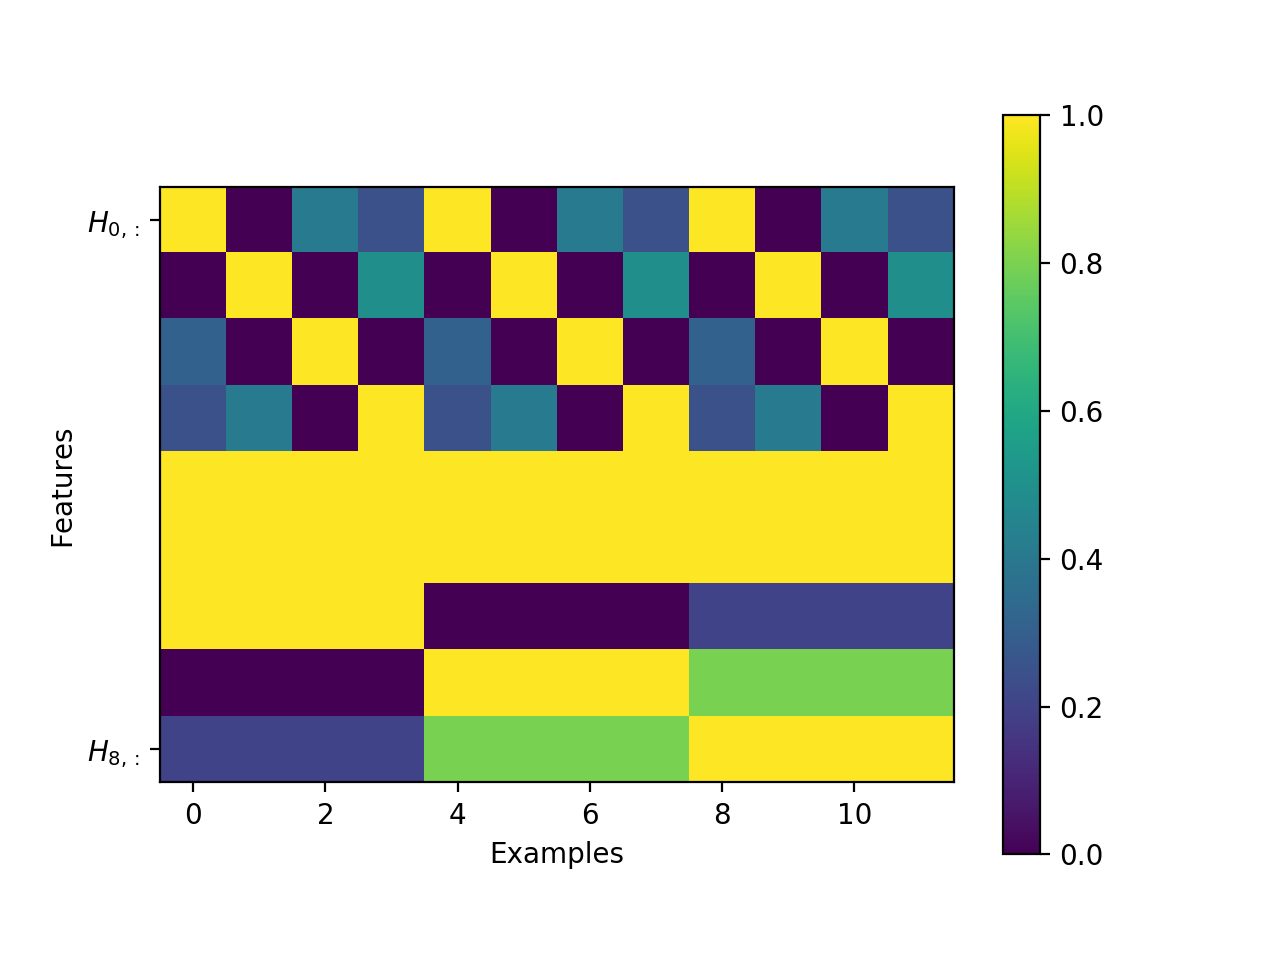

<IPython.core.display.Javascript object>


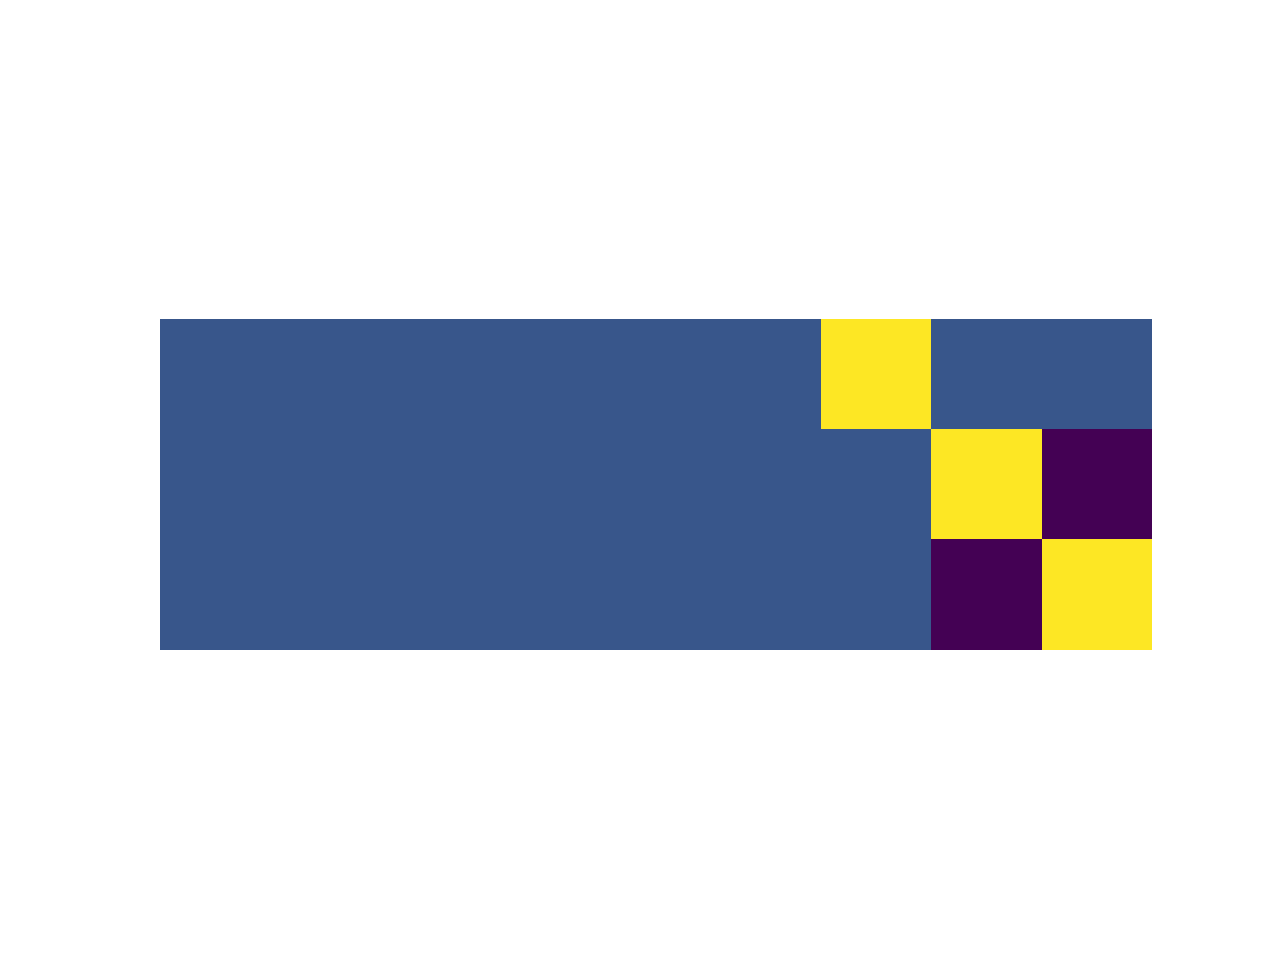

<IPython.core.display.Javascript object>


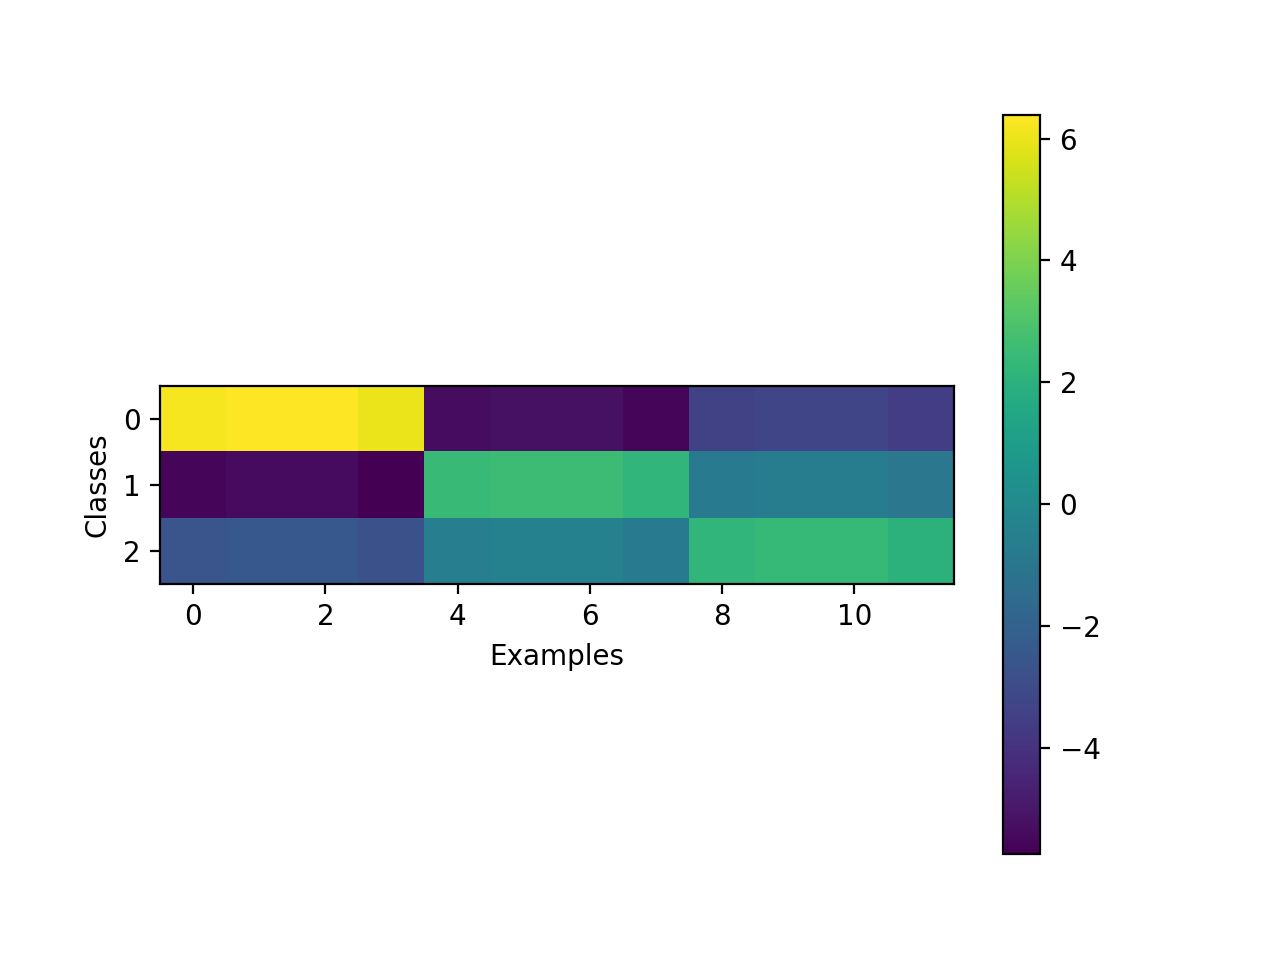

<IPython.core.display.Javascript object>


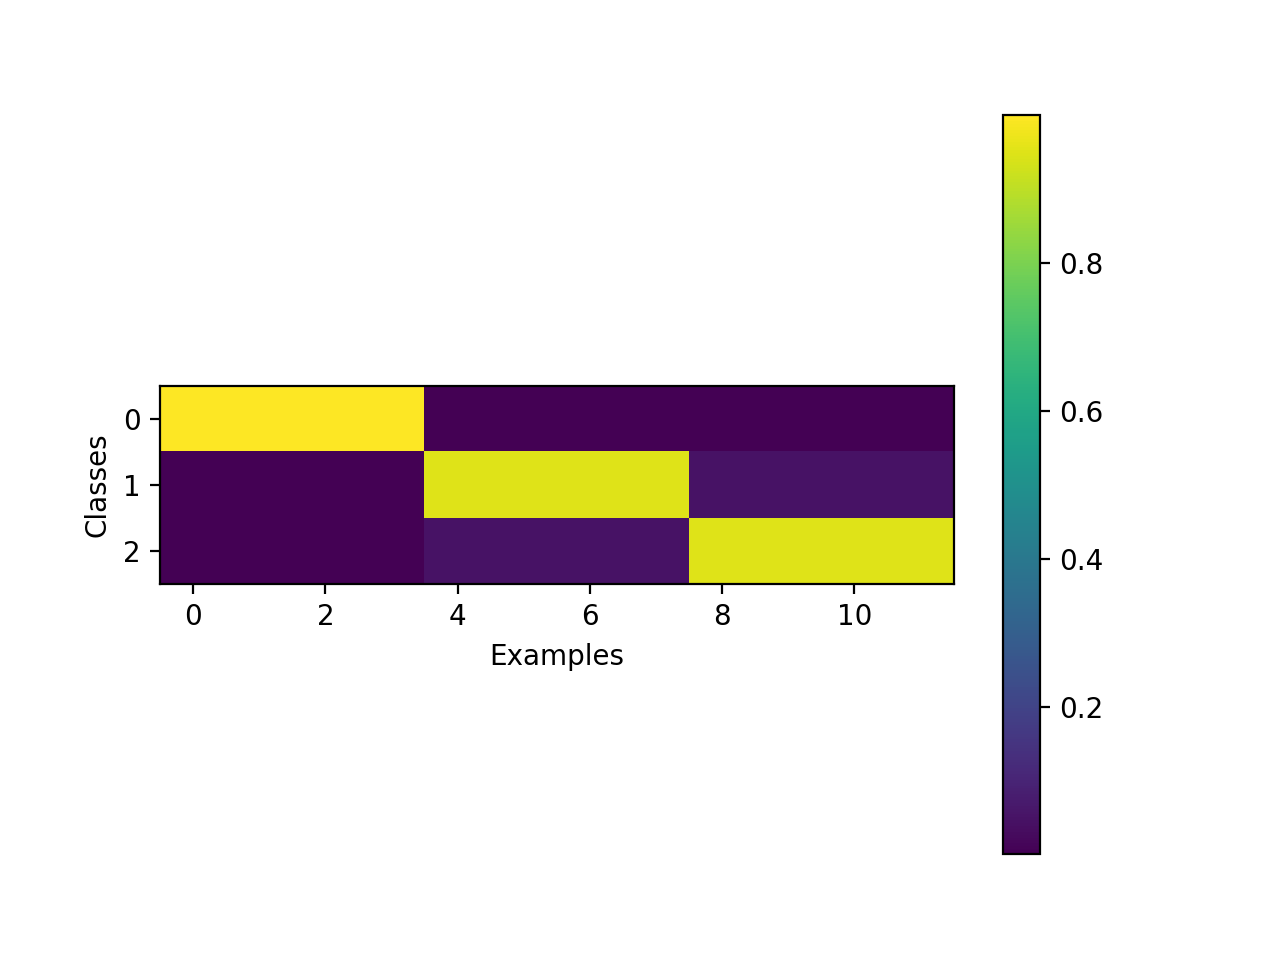

Text(0,0.5,'Classes')

In [22]:
Wn=W/np.sum(W,axis=1).reshape((9,1))

Z=X.dot(Wn.T)
plt.figure()
plt.imshow(Z.T)
plt.colorbar()
plt.ylabel('Features')
plt.xlabel('Examples')
plt.yticks([0,8], [r'$H_{0,:}$', r'$H_{8,:}$'])

W2=np.array([[-1,-1,-1,-1,-1,-1,10,-1,-1],[-1,-1,-1,-1,-1,-1,-1,10,-5],[-1,-1,-1,-1,-1,-1,-1,-5,10]])

plt.figure()
plt.imshow(W2)
plt.axis('off')
plt.xlabel('Examples')

Z2=Z.dot(W2.T)
plt.figure()
plt.imshow(Z2.T)
plt.colorbar()
plt.xlabel('Examples')
plt.ylabel('Classes')


plt.figure()
plt.imshow(np.exp(Z2.T)/np.sum(np.exp(Z2.T), axis=0))
plt.colorbar()
plt.xlabel('Examples')
plt.ylabel('Classes')

